In [1]:
# import os
from tqdm import trange
# import wandb

# import re
import gymnasium as gym
# from llamagym import Agent
import numpy as np
import d3rlpy
import pickle

# from gymnasium_env import BlackjackWrapper
import matplotlib.pyplot as plt
from atariari.benchmark.wrapper import AtariARIWrapper
from env.atari.represented_atari_game import GymCompatWrapper2

class InputParams:
    def __init__(self):
        self.env="RepresentedSpaceInvaders-v0"
        self.seed=1
        self.gpu=True

args=InputParams()
n_pretrain_eps = 1
n_online_eps = 9

# d3rlpy supports both Gym and Gymnasium
env = GymCompatWrapper2(gym.make(args.env))
eval_env = GymCompatWrapper2(gym.make(args.env))

# # fix seed
# d3rlpy.seed(args.seed)
# d3rlpy.envs.seed_env(env, args.seed)
# d3rlpy.envs.seed_env(eval_env, args.seed)

2025-03-29 17:18.53 [info     ] Register Shimmy environments. 


/home/thangduong/miniconda3/envs/llamagym/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]
/home/thangduong/miniconda3/envs/llamagym/lib/python3.9/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.labels to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.labels` for environment variables or `env.get_wrapper_attr('labels')` that will search the reminding wrappers.
  logger.warn(
/home/thangduong/miniconda3/envs/llamagym/lib/python3.9/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.spec to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.spec` for environment 

## Offline pretraining

In [2]:
# # setup algorithm
# llama_dqn = d3rlpy.algos.DQNConfig(
#     batch_size=32,
#     learning_rate=6.25e-5,
#     ).create(device=args.gpu)

# with open('data/random_eps_5000.pkl', 'rb') as file:
# # with open('data/Qwen2.5-0.5B_eps_5000.pkl', 'rb') as file:
# # with open('data/meta-llama_Llama-2-7b-chat-hf_eps_5000.pkl', 'rb') as file:
#     dataset = pickle.load(file)

# # start offline training
# llama_dqn.fit(dataset, n_steps=1300) #Around 500 eps here

# with open('models/dqn_random_eps_500.pkl', 'wb') as file:
# # with open('models/dqn_Qwen2.5-0.5B_eps_500.pkl', 'wb') as file:
# # with open('models/dqn_llama_eps_500.pkl', 'wb') as file:
#         pickle.dump(llama_dqn, file)

## Load pretrained model and online training

In [ ]:
def online_training(
    env,
    eval_env,
    explorer=None,
    model_path=None,
    model=None,
    data_path=None,
    n_pretrain_eps=125,
    limit=1000000,
    n_steps=1050,
    n_steps_per_epoch=300,
    # update_interval=1,
    cut_off_threshold=None,
    gpu=True
):
    # Load model with proper validation
    if model_path:
        with open(model_path, 'rb') as file:
            dqn = pickle.load(file)
    elif model:
        dqn = model
    else:
        dqn = d3rlpy.algos.DQNConfig(
            batch_size=32,
            learning_rate=6.25e-5,
            ).create(device=gpu)

    # Initialize empty FIFO buffer
    buffer = d3rlpy.dataset.ReplayBuffer(
        buffer=d3rlpy.dataset.FIFOBuffer(limit=limit),
        env=env,
    )
    
    # Load and merge offline data with type-checking
    if data_path:
        try:
            # Load dataset with proper validation
            with open(data_path, 'rb') as f:
                dataset = pickle.load(f)
            
            # Verify dataset structure
            if hasattr(dataset, 'episodes'):
                # Calculate safe episode count to load
                valid_episodes = min(n_pretrain_eps, len(dataset.episodes))
                
                # Append episodes with transition validation
                for episode in dataset.episodes[:valid_episodes]:
                    if len(episode) > 0 and hasattr(episode, 'rewards'):
                        buffer.append_episode(episode)
                    else:
                        print(f"Skipping invalid episode: {episode}")
        except Exception as e:
            print(f"Error loading dataset: {str(e)}")

    # Configure training with safety checks
    if buffer.transition_count == 0:
        print("Empty buffer (just Online training)!")
    dqn.fit_online(
        env=env,
        buffer=buffer,
        explorer=explorer,
        eval_env=eval_env,
        n_steps=n_steps,
        n_steps_per_epoch=n_steps_per_epoch,
        # update_interval=update_interval,
        # experiment_name="online_training",
    )

    # Extract rewards safely
    rewards = []
    for episode in buffer.episodes: # Only collect the online data
        rewards.extend(episode.compute_return())
    
    if cut_off_threshold:
        start, end = cut_off_threshold
        rewards = rewards[start:end]
    return rewards

## Data collection

### Static/pretrain data

In [3]:
with open('data/SpaceInvaders_Qwen2.5-0.5B-Instruct_Neps_1.pkl', 'rb') as file:
    Qwen_small_dataset = pickle.load(file)
    
with open('data/SpaceInvaders_rand_Neps_2.pkl', 'rb') as file:
    rand_dataset = pickle.load(file)
    
with open('data/SpaceInvaders_Qwen2.5-7B-Instruct_Neps_1.pkl', 'rb') as file:
    Qwen_7B_dataset = pickle.load(file)

#TODO: wrong
Qwen_small_rewards = []
for i in range(n_pretrain_eps):
    Qwen_small_rewards.append(Qwen_small_dataset.episodes[i].rewards[0,0])
rand_rewards = []
for i in range(n_pretrain_eps):
    rand_rewards.append(rand_dataset.episodes[i].rewards[0,0])
Qwen_7B_rewards = []
for i in range(n_pretrain_eps):
    Qwen_7B_rewards.append(Qwen_7B_dataset.episodes[i].rewards[0,0])

Qwen_avg = np.ones(n_pretrain_eps + n_online_eps) * np.mean(Qwen_small_rewards)
rand_avg = np.ones(n_pretrain_eps + n_online_eps) * np.mean(rand_rewards)
Qwen_7B_avg = np.ones(n_pretrain_eps + n_online_eps) * np.mean(Qwen_7B_rewards)

### Some optinal validation code

In [ ]:
print(env.labels(), env.action_space, env.observation_space)

from env.atari.SpaceInvaders_translator import ObsTranslator
translator = ObsTranslator()

# len(rand_dataset.episodes)
c = 0
for e in Qwen_7B_dataset.episodes:
    if len(e.observations)>1:
        print(e.observations.shape)
        print(e.actions.shape)
        print(e.rewards.shape)
        print('------------------')
        c+=1
    else:
        print(e.observations.shape)
        print(translator.translate(e.observations[0]))
        break
    
print(f"# of valid episodes (>1 obs) in the dataset: {c}")

(189, 7)
(189, 1)
(189, 1)
------------------
(1, 7)
You are at position x=35. Number of invaders left: 36. Player's score: 0. Number of lives left: 0. Enemies are at positions: [48, 80]. Missiles are at y positions: [13].
# of valid episodes (>1 obs) in the dataset: 1


### Online data

In [ ]:
n_exp = 3
# llama_LORO_rewards = np.zeros((n_pretrain_eps + n_online_eps, n_exp))
# Qwen_LORO_rewards = np.zeros((n_pretrain_eps + n_online_eps, n_exp))
# rand_LORO_rewards = np.zeros((n_pretrain_eps + n_online_eps, n_exp))
# onl_rewards = np.zeros((n_pretrain_eps + n_online_eps, n_exp))
# onl_rewards_eps = np.zeros((n_pretrain_eps + n_online_eps, n_exp))
# onl_rewards_eps_decay = np.zeros((n_pretrain_eps + n_online_eps, n_exp))

n_steps = 1400
n_pretrain_steps = 0

onl_rewards = np.zeros((n_steps, n_exp))
onl_rewards_eps = np.zeros((n_steps, n_exp))
onl_rewards_eps_decay = np.zeros((n_steps, n_exp))

# setup explorers
const_explorer = d3rlpy.algos.ConstantEpsilonGreedy(0.3)
decay_explorer = d3rlpy.algos.LinearDecayEpsilonGreedy(
    start_epsilon=1.0,
    end_epsilon=0.1,
    duration=10,
)
for i in range(n_exp):
    # llama_LORO_rewards[n_pretrain_eps:,i] = online_training(env, eval_env, data_path='data/meta-llama_Llama-2-7b-chat-hf_eps_5000.pkl', n_pretrain_eps=n_pretrain_eps)
    # Qwen_LORO_rewards[n_pretrain_eps:,i] = online_training(env, eval_env, data_path='data/Qwen2.5-0.5B_eps_5000.pkl', n_pretrain_eps=n_pretrain_eps)
    # rand_LORO_rewards[n_pretrain_eps:,i] = online_training(env, eval_env, data_path='data/random_eps_5000.pkl', n_pretrain_eps=n_pretrain_eps) #list length 250 here
    onl_rewards[:,i] = online_training(env, eval_env, n_steps=n_steps)
    onl_rewards_eps[:,i] = online_training(env, eval_env, const_explorer, n_steps=n_steps)
    onl_rewards_eps_decay[:,i] = online_training(env, eval_env, decay_explorer, n_steps=n_steps)

2025-03-27 23:16.30 [info     ] Signatures have been automatically determined. action_signature=Signature(dtype=[dtype('int64')], shape=[()]) observation_signature=Signature(dtype=[dtype('float32')], shape=[(7,)]) reward_signature=Signature(dtype=[dtype('float32')], shape=[[1]])
2025-03-27 23:16.30 [info     ] Action-space has been automatically determined. action_space=<ActionSpace.DISCRETE: 2>
2025-03-27 23:16.30 [info     ] Action size has been automatically determined. action_size=6
Empty buffer (just Online training)!
2025-03-27 23:16.30 [info     ] Directory is created at d3rlpy_logs/DQN_online_20250327231630
2025-03-27 23:16.30 [debug    ] Building model...             
2025-03-27 23:16.30 [debug    ] Model has been built.         
2025-03-27 23:16.30 [info     ] Parameters                     params={'observation_shape': [7], 'action_size': 6, 'config': {'type': 'dqn', 'params': {'batch_size': 32, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scal

/home/thangduong/miniconda3/envs/llamagym/lib/python3.9/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.labels to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.labels` for environment variables or `env.get_wrapper_attr('labels')` that will search the reminding wrappers.
  logger.warn(
  6%|▌         | 87/1400 [00:00<00:08, 157.47it/s]

2025-03-27 23:16.37 [info     ] Model parameters are saved to d3rlpy_logs/DQN_online_20250327231630/model_100.d3
2025-03-27 23:16.37 [info     ] DQN_online_20250327231630: epoch=1 step=100 epoch=1 metrics={'time_inference': 0.0012018084526062012, 'time_environment_step': 0.000985994338989258, 'time_step': 0.00619908094406128, 'time_sample_batch': 0.0003600156129296146, 'time_algorithm_update': 0.00557118031516004, 'loss': 0.6037541579840872, 'evaluation': 20.0} step=100


 14%|█▍        | 198/1400 [00:07<00:28, 42.84it/s]

2025-03-27 23:16.42 [info     ] Model parameters are saved to d3rlpy_logs/DQN_online_20250327231630/model_200.d3
2025-03-27 23:16.42 [info     ] DQN_online_20250327231630: epoch=2 step=200 epoch=2 metrics={'time_inference': 0.0006432747840881348, 'time_environment_step': 0.0009840774536132814, 'time_sample_batch': 0.0003481149673461914, 'time_algorithm_update': 0.0035598063468933105, 'loss': 0.724759421646595, 'time_step': 0.005573339462280273, 'evaluation': 70.0} step=200


 21%|██        | 293/1400 [00:13<00:28, 39.23it/s]

2025-03-27 23:16.48 [info     ] Model parameters are saved to d3rlpy_logs/DQN_online_20250327231630/model_300.d3
2025-03-27 23:16.48 [info     ] DQN_online_20250327231630: epoch=3 step=300 epoch=3 metrics={'time_inference': 0.0006753921508789063, 'time_environment_step': 0.0010001492500305176, 'time_sample_batch': 0.000365145206451416, 'time_algorithm_update': 0.003654060363769531, 'loss': 0.8017120426148177, 'time_step': 0.00573596715927124, 'evaluation': 110.0} step=300


 28%|██▊       | 391/1400 [00:18<00:28, 35.77it/s]

2025-03-27 23:16.54 [info     ] Model parameters are saved to d3rlpy_logs/DQN_online_20250327231630/model_400.d3
2025-03-27 23:16.54 [info     ] DQN_online_20250327231630: epoch=4 step=400 epoch=4 metrics={'time_inference': 0.0005040812492370605, 'time_environment_step': 0.0010235190391540527, 'time_sample_batch': 0.00037948846817016603, 'time_algorithm_update': 0.0031204891204833986, 'loss': 0.6119603192806244, 'time_step': 0.00506908655166626, 'evaluation': 105.0} step=400


 36%|███▌      | 497/1400 [00:24<00:22, 40.49it/s]

2025-03-27 23:17.01 [info     ] Model parameters are saved to d3rlpy_logs/DQN_online_20250327231630/model_500.d3
2025-03-27 23:17.01 [info     ] DQN_online_20250327231630: epoch=5 step=500 epoch=5 metrics={'time_inference': 0.0007004761695861817, 'time_environment_step': 0.0010331535339355468, 'time_sample_batch': 0.0004156184196472168, 'time_algorithm_update': 0.0038153743743896485, 'loss': 1.0467974111437797, 'time_step': 0.00697291374206543, 'rollout_return': 350.0, 'evaluation': 20.0} step=500


 42%|████▏     | 583/1400 [00:31<00:28, 28.48it/s]

2025-03-27 23:17.07 [info     ] Model parameters are saved to d3rlpy_logs/DQN_online_20250327231630/model_600.d3
2025-03-27 23:17.07 [info     ] DQN_online_20250327231630: epoch=6 step=600 epoch=6 metrics={'time_inference': 0.0006474590301513672, 'time_environment_step': 0.0010625028610229492, 'time_sample_batch': 0.0004123353958129883, 'time_algorithm_update': 0.003564651012420654, 'loss': 1.1110643208771944, 'time_step': 0.005736911296844482, 'evaluation': 30.0} step=600


 49%|████▉     | 689/1400 [00:37<00:17, 39.81it/s]

2025-03-27 23:17.13 [info     ] Model parameters are saved to d3rlpy_logs/DQN_online_20250327231630/model_700.d3
2025-03-27 23:17.13 [info     ] DQN_online_20250327231630: epoch=7 step=700 epoch=7 metrics={'time_inference': 0.0005939054489135742, 'time_environment_step': 0.0010240530967712401, 'time_sample_batch': 0.0003977179527282715, 'time_algorithm_update': 0.0034947109222412107, 'loss': 1.327132053039968, 'time_step': 0.006542463302612305, 'rollout_return': 145.0, 'evaluation': 55.0} step=700


 57%|█████▋    | 796/1400 [00:43<00:13, 45.10it/s]

2025-03-27 23:17.20 [info     ] Model parameters are saved to d3rlpy_logs/DQN_online_20250327231630/model_800.d3
2025-03-27 23:17.20 [info     ] DQN_online_20250327231630: epoch=8 step=800 epoch=8 metrics={'time_inference': 0.0005913114547729492, 'time_environment_step': 0.001049022674560547, 'time_sample_batch': 0.0003995800018310547, 'time_algorithm_update': 0.003499696254730225, 'loss': 1.1033697114884853, 'time_step': 0.005586905479431152, 'evaluation': 70.0} step=800


 63%|██████▎   | 887/1400 [00:50<00:17, 28.72it/s]

2025-03-27 23:17.26 [info     ] Model parameters are saved to d3rlpy_logs/DQN_online_20250327231630/model_900.d3
2025-03-27 23:17.26 [info     ] DQN_online_20250327231630: epoch=9 step=900 epoch=9 metrics={'time_inference': 0.0006364107131958008, 'time_environment_step': 0.0009978151321411134, 'time_sample_batch': 0.0003830742835998535, 'time_algorithm_update': 0.0035020589828491213, 'loss': 1.0160144163668157, 'time_step': 0.005562703609466552, 'evaluation': 75.0} step=900


 71%|███████   | 997/1400 [00:56<00:09, 43.13it/s]

2025-03-27 23:17.32 [info     ] Model parameters are saved to d3rlpy_logs/DQN_online_20250327231630/model_1000.d3
2025-03-27 23:17.32 [info     ] DQN_online_20250327231630: epoch=10 step=1000 epoch=10 metrics={'time_inference': 0.0005287480354309082, 'time_environment_step': 0.001020333766937256, 'time_sample_batch': 0.00041736841201782225, 'time_algorithm_update': 0.0030658125877380373, 'loss': 1.1354799143970014, 'time_step': 0.006076579093933106, 'rollout_return': 100.0, 'evaluation': 95.0} step=1000


 78%|███████▊  | 1090/1400 [01:02<00:08, 35.11it/s]

2025-03-27 23:17.38 [info     ] Model parameters are saved to d3rlpy_logs/DQN_online_20250327231630/model_1100.d3
2025-03-27 23:17.38 [info     ] DQN_online_20250327231630: epoch=11 step=1100 epoch=11 metrics={'time_inference': 0.0006047606468200684, 'time_environment_step': 0.0010452675819396973, 'time_sample_batch': 0.0004279470443725586, 'time_algorithm_update': 0.003378901481628418, 'loss': 0.8742982904613018, 'time_step': 0.005508663654327392, 'evaluation': 75.0} step=1100


 85%|████████▍ | 1184/1400 [01:08<00:06, 32.22it/s]

2025-03-27 23:17.44 [info     ] Model parameters are saved to d3rlpy_logs/DQN_online_20250327231630/model_1200.d3
2025-03-27 23:17.44 [info     ] DQN_online_20250327231630: epoch=12 step=1200 epoch=12 metrics={'time_inference': 0.0005610346794128418, 'time_environment_step': 0.0010404181480407715, 'time_sample_batch': 0.00038873672485351563, 'time_algorithm_update': 0.0032620501518249513, 'loss': 0.8465869136154651, 'time_step': 0.006266489028930664, 'rollout_return': 95.0, 'evaluation': 100.0} step=1200


 92%|█████████▏| 1283/1400 [01:14<00:02, 41.27it/s]

2025-03-27 23:17.49 [info     ] Model parameters are saved to d3rlpy_logs/DQN_online_20250327231630/model_1300.d3
2025-03-27 23:17.49 [info     ] DQN_online_20250327231630: epoch=13 step=1300 epoch=13 metrics={'time_inference': 0.0007385063171386719, 'time_environment_step': 0.0011154818534851074, 'time_sample_batch': 0.000451509952545166, 'time_algorithm_update': 0.0036751604080200195, 'loss': 1.117249871492386, 'time_step': 0.006034088134765625, 'evaluation': 100.0} step=1300


 99%|█████████▉| 1391/1400 [01:20<00:00, 44.52it/s]

2025-03-27 23:17.56 [info     ] Model parameters are saved to d3rlpy_logs/DQN_online_20250327231630/model_1400.d3
2025-03-27 23:17.56 [info     ] DQN_online_20250327231630: epoch=14 step=1400 epoch=14 metrics={'time_inference': 0.0005725717544555664, 'time_environment_step': 0.0010577082633972169, 'time_sample_batch': 0.0004211735725402832, 'time_algorithm_update': 0.0036347532272338868, 'loss': 1.049690273553133, 'time_step': 0.005734367370605469, 'evaluation': 95.0} step=1400


100%|██████████| 1400/1400 [01:25<00:00, 16.29it/s]

2025-03-27 23:17.56 [info     ] Signatures have been automatically determined. action_signature=Signature(dtype=[dtype('int64')], shape=[()]) observation_signature=Signature(dtype=[dtype('float32')], shape=[(7,)]) reward_signature=Signature(dtype=[dtype('float32')], shape=[[1]])
2025-03-27 23:17.56 [info     ] Action-space has been automatically determined. action_space=<ActionSpace.DISCRETE: 2>
2025-03-27 23:17.56 [info     ] Action size has been automatically determined. action_size=6
Empty buffer (just Online training)!
2025-03-27 23:17.56 [info     ] Directory is created at d3rlpy_logs/DQN_online_20250327231756
2025-03-27 23:17.56 [debug    ] Building model...             
2025-03-27 23:17.56 [debug    ] Model has been built.         
2025-03-27 23:17.56 [info     ] Parameters                     params={'observation_shape': [7], 'action_size': 6, 'config': {'type': 'dqn', 'params': {'batch_size': 32, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scal


  5%|▌         | 76/1400 [00:00<00:06, 203.59it/s]

2025-03-27 23:18.01 [info     ] Model parameters are saved to d3rlpy_logs/DQN_online_20250327231756/model_100.d3
2025-03-27 23:18.01 [info     ] DQN_online_20250327231756: epoch=1 step=100 epoch=1 metrics={'time_inference': 0.0008317756652832031, 'time_environment_step': 0.0011735963821411133, 'time_step': 0.005324475765228272, 'time_sample_batch': 0.00047130727056247083, 'time_algorithm_update': 0.004384389564172545, 'loss': 1.178329660376506, 'evaluation': 45.0} step=100


 14%|█▍        | 194/1400 [00:05<00:22, 54.23it/s]

2025-03-27 23:18.10 [info     ] Model parameters are saved to d3rlpy_logs/DQN_online_20250327231756/model_200.d3
2025-03-27 23:18.10 [info     ] DQN_online_20250327231756: epoch=2 step=200 epoch=2 metrics={'time_inference': 0.0006806564331054688, 'time_environment_step': 0.0010869050025939942, 'time_sample_batch': 0.0004052138328552246, 'time_algorithm_update': 0.003309183120727539, 'loss': 0.8453141066432, 'time_step': 0.0055308365821838375, 'evaluation': 160.0} step=200


 20%|██        | 280/1400 [00:14<00:48, 23.15it/s]

2025-03-27 23:18.17 [info     ] Model parameters are saved to d3rlpy_logs/DQN_online_20250327231756/model_300.d3
2025-03-27 23:18.17 [info     ] DQN_online_20250327231756: epoch=3 step=300 epoch=3 metrics={'time_inference': 0.0006466507911682129, 'time_environment_step': 0.0010731220245361328, 'time_sample_batch': 0.0004038023948669434, 'time_algorithm_update': 0.0036609673500061033, 'loss': 0.9335188826918602, 'time_step': 0.005833420753479004, 'evaluation': 115.0} step=300


 28%|██▊       | 394/1400 [00:22<00:23, 42.12it/s]

2025-03-27 23:18.24 [info     ] Model parameters are saved to d3rlpy_logs/DQN_online_20250327231756/model_400.d3
2025-03-27 23:18.24 [info     ] DQN_online_20250327231756: epoch=4 step=400 epoch=4 metrics={'time_inference': 0.0007251596450805664, 'time_environment_step': 0.0010235071182250976, 'time_sample_batch': 0.0003727936744689941, 'time_algorithm_update': 0.00390547513961792, 'loss': 0.7349270288646221, 'time_step': 0.007036039829254151, 'rollout_return': 110.0, 'evaluation': 120.0} step=400


 36%|███▌      | 498/1400 [00:29<00:23, 37.83it/s]

2025-03-27 23:18.31 [info     ] Model parameters are saved to d3rlpy_logs/DQN_online_20250327231756/model_500.d3
2025-03-27 23:18.31 [info     ] DQN_online_20250327231756: epoch=5 step=500 epoch=5 metrics={'time_inference': 0.0006260037422180176, 'time_environment_step': 0.0010535407066345215, 'time_sample_batch': 0.00039604425430297854, 'time_algorithm_update': 0.003651986122131348, 'loss': 0.8005200880765915, 'time_step': 0.005771512985229492, 'evaluation': 25.0} step=500


 42%|████▎     | 595/1400 [00:35<00:24, 33.22it/s]

2025-03-27 23:18.38 [info     ] Model parameters are saved to d3rlpy_logs/DQN_online_20250327231756/model_600.d3
2025-03-27 23:18.38 [info     ] DQN_online_20250327231756: epoch=6 step=600 epoch=6 metrics={'time_inference': 0.0005581355094909667, 'time_environment_step': 0.001008925437927246, 'time_sample_batch': 0.00037943124771118165, 'time_algorithm_update': 0.0030437302589416504, 'loss': 0.8311021253466606, 'time_step': 0.005029690265655517, 'evaluation': 100.0} step=600


 49%|████▉     | 688/1400 [00:42<00:26, 26.67it/s]

2025-03-27 23:18.43 [info     ] Model parameters are saved to d3rlpy_logs/DQN_online_20250327231756/model_700.d3
2025-03-27 23:18.43 [info     ] DQN_online_20250327231756: epoch=7 step=700 epoch=7 metrics={'time_inference': 0.0005820012092590332, 'time_environment_step': 0.0009814190864562988, 'time_sample_batch': 0.0003802323341369629, 'time_algorithm_update': 0.0031830120086669923, 'loss': 1.0652678698301314, 'time_step': 0.006343836784362793, 'rollout_return': 370.0, 'evaluation': 50.0} step=700


 57%|█████▋    | 792/1400 [00:48<00:14, 41.94it/s]

2025-03-27 23:18.52 [info     ] Model parameters are saved to d3rlpy_logs/DQN_online_20250327231756/model_800.d3
2025-03-27 23:18.52 [info     ] DQN_online_20250327231756: epoch=8 step=800 epoch=8 metrics={'time_inference': 0.0007042932510375977, 'time_environment_step': 0.0010788583755493165, 'time_sample_batch': 0.00041436195373535157, 'time_algorithm_update': 0.003627808094024658, 'loss': 1.0056613297760486, 'time_step': 0.0058735466003417966, 'evaluation': 150.0} step=800


 64%|██████▍   | 896/1400 [00:56<00:14, 35.68it/s]

2025-03-27 23:18.58 [info     ] Model parameters are saved to d3rlpy_logs/DQN_online_20250327231756/model_900.d3
2025-03-27 23:18.58 [info     ] DQN_online_20250327231756: epoch=9 step=900 epoch=9 metrics={'time_inference': 0.0007322001457214356, 'time_environment_step': 0.0010567069053649901, 'time_sample_batch': 0.0004060959815979004, 'time_algorithm_update': 0.0038048386573791503, 'loss': 0.8549084144085646, 'time_step': 0.00604891300201416, 'evaluation': 315.0} step=900


 71%|███████   | 996/1400 [01:03<00:12, 32.19it/s]

2025-03-27 23:19.05 [info     ] Model parameters are saved to d3rlpy_logs/DQN_online_20250327231756/model_1000.d3
2025-03-27 23:19.05 [info     ] DQN_online_20250327231756: epoch=10 step=1000 epoch=10 metrics={'time_inference': 0.0005803442001342773, 'time_environment_step': 0.0010305953025817871, 'time_sample_batch': 0.0003879714012145996, 'time_algorithm_update': 0.003041532039642334, 'loss': 1.0158501367270947, 'time_step': 0.0050821065902709964, 'evaluation': 10.0} step=1000


 78%|███████▊  | 1098/1400 [01:10<00:08, 36.55it/s]

2025-03-27 23:19.10 [info     ] Model parameters are saved to d3rlpy_logs/DQN_online_20250327231756/model_1100.d3
2025-03-27 23:19.10 [info     ] DQN_online_20250327231756: epoch=11 step=1100 epoch=11 metrics={'time_inference': 0.0008191895484924316, 'time_environment_step': 0.00103438138961792, 'time_sample_batch': 0.00041429519653320314, 'time_algorithm_update': 0.0039388489723205565, 'loss': 0.9477680259943009, 'time_step': 0.006257855892181396, 'evaluation': 25.0} step=1100


 85%|████████▌ | 1190/1400 [01:15<00:05, 37.85it/s]

2025-03-27 23:19.19 [info     ] Model parameters are saved to d3rlpy_logs/DQN_online_20250327231756/model_1200.d3
2025-03-27 23:19.19 [info     ] DQN_online_20250327231756: epoch=12 step=1200 epoch=12 metrics={'time_inference': 0.0006017112731933594, 'time_environment_step': 0.001025099754333496, 'time_sample_batch': 0.00038892030715942383, 'time_algorithm_update': 0.003324556350708008, 'loss': 0.8360486370325089, 'time_step': 0.006361105442047119, 'rollout_return': 100.0, 'evaluation': 35.0} step=1200


 92%|█████████▏| 1288/1400 [01:23<00:04, 26.59it/s]

2025-03-27 23:19.23 [info     ] Model parameters are saved to d3rlpy_logs/DQN_online_20250327231756/model_1300.d3
2025-03-27 23:19.23 [info     ] DQN_online_20250327231756: epoch=13 step=1300 epoch=13 metrics={'time_inference': 0.0005637168884277344, 'time_environment_step': 0.0010082721710205078, 'time_sample_batch': 0.0003748631477355957, 'time_algorithm_update': 0.003086833953857422, 'loss': 0.8733448155224324, 'time_step': 0.005074687004089355, 'evaluation': 0.0} step=1300


100%|█████████▉| 1399/1400 [01:27<00:00, 58.55it/s]

2025-03-27 23:19.28 [info     ] Model parameters are saved to d3rlpy_logs/DQN_online_20250327231756/model_1400.d3
2025-03-27 23:19.28 [info     ] DQN_online_20250327231756: epoch=14 step=1400 epoch=14 metrics={'time_inference': 0.0006833291053771973, 'time_environment_step': 0.0010090088844299317, 'time_sample_batch': 0.00040787458419799805, 'time_algorithm_update': 0.00366168737411499, 'loss': 1.0322286036610604, 'time_step': 0.005804486274719238, 'evaluation': 30.0} step=1400


100%|██████████| 1400/1400 [01:32<00:00, 15.18it/s]

2025-03-27 23:19.28 [info     ] Signatures have been automatically determined. action_signature=Signature(dtype=[dtype('int64')], shape=[()]) observation_signature=Signature(dtype=[dtype('float32')], shape=[(7,)]) reward_signature=Signature(dtype=[dtype('float32')], shape=[[1]])
2025-03-27 23:19.28 [info     ] Action-space has been automatically determined. action_space=<ActionSpace.DISCRETE: 2>
2025-03-27 23:19.28 [info     ] Action size has been automatically determined. action_size=6
Empty buffer (just Online training)!
2025-03-27 23:19.28 [info     ] Directory is created at d3rlpy_logs/DQN_online_20250327231928
2025-03-27 23:19.28 [debug    ] Building model...             
2025-03-27 23:19.28 [debug    ] Model has been built.         
2025-03-27 23:19.28 [info     ] Parameters                     params={'observation_shape': [7], 'action_size': 6, 'config': {'type': 'dqn', 'params': {'batch_size': 32, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scal


  6%|▌         | 79/1400 [00:00<00:06, 216.21it/s]

2025-03-27 23:19.35 [info     ] Model parameters are saved to d3rlpy_logs/DQN_online_20250327231928/model_100.d3
2025-03-27 23:19.35 [info     ] DQN_online_20250327231928: epoch=1 step=100 epoch=1 metrics={'time_inference': 0.0007459115982055664, 'time_environment_step': 0.001028149127960205, 'time_step': 0.004868021011352539, 'time_sample_batch': 0.0003620119237188083, 'time_algorithm_update': 0.004201077703219741, 'loss': 0.6879094881353094, 'evaluation': 65.0} step=100


 13%|█▎        | 188/1400 [00:07<00:29, 41.28it/s]

2025-03-27 23:19.42 [info     ] Model parameters are saved to d3rlpy_logs/DQN_online_20250327231928/model_200.d3
2025-03-27 23:19.42 [info     ] DQN_online_20250327231928: epoch=2 step=200 epoch=2 metrics={'time_inference': 0.000650787353515625, 'time_environment_step': 0.0011639904975891114, 'time_sample_batch': 0.00041880130767822264, 'time_algorithm_update': 0.003989992141723633, 'loss': 0.9497415198385716, 'time_step': 0.006278624534606933, 'evaluation': 125.0} step=200


 21%|██▏       | 299/1400 [00:14<00:29, 37.82it/s]

2025-03-27 23:19.47 [info     ] Model parameters are saved to d3rlpy_logs/DQN_online_20250327231928/model_300.d3
2025-03-27 23:19.47 [info     ] DQN_online_20250327231928: epoch=3 step=300 epoch=3 metrics={'time_inference': 0.0006119060516357422, 'time_environment_step': 0.0010365962982177735, 'time_sample_batch': 0.0003902316093444824, 'time_algorithm_update': 0.0033081889152526854, 'loss': 0.9292292860150337, 'time_step': 0.005392055511474609, 'evaluation': 80.0} step=300


 28%|██▊       | 393/1400 [00:19<00:25, 39.95it/s]

2025-03-27 23:19.52 [info     ] Model parameters are saved to d3rlpy_logs/DQN_online_20250327231928/model_400.d3
2025-03-27 23:19.52 [info     ] DQN_online_20250327231928: epoch=4 step=400 epoch=4 metrics={'time_inference': 0.0006202435493469238, 'time_environment_step': 0.0010121369361877441, 'time_sample_batch': 0.0003803277015686035, 'time_algorithm_update': 0.0033915901184082033, 'loss': 1.3152247795462608, 'time_step': 0.005448014736175537, 'evaluation': 30.0} step=400


 35%|███▍      | 489/1400 [00:24<00:20, 45.30it/s]

2025-03-27 23:19.58 [info     ] Model parameters are saved to d3rlpy_logs/DQN_online_20250327231928/model_500.d3
2025-03-27 23:19.58 [info     ] DQN_online_20250327231928: epoch=5 step=500 epoch=5 metrics={'time_inference': 0.0006782078742980957, 'time_environment_step': 0.0010108399391174317, 'time_sample_batch': 0.0004140758514404297, 'time_algorithm_update': 0.004215056896209717, 'loss': 1.530234969854355, 'time_step': 0.007346358299255371, 'rollout_return': 340.0, 'evaluation': 105.0} step=500


 43%|████▎     | 596/1400 [00:30<00:15, 51.76it/s]

2025-03-27 23:20.04 [info     ] Model parameters are saved to d3rlpy_logs/DQN_online_20250327231928/model_600.d3
2025-03-27 23:20.04 [info     ] DQN_online_20250327231928: epoch=6 step=600 epoch=6 metrics={'time_inference': 0.0008670449256896973, 'time_environment_step': 0.0010649394989013673, 'time_sample_batch': 0.0004035592079162598, 'time_algorithm_update': 0.004284853935241699, 'loss': 1.3023189662396908, 'time_step': 0.006672132015228272, 'evaluation': 50.0} step=600


 49%|████▉     | 687/1400 [00:36<00:20, 35.24it/s]

2025-03-27 23:20.10 [info     ] Model parameters are saved to d3rlpy_logs/DQN_online_20250327231928/model_700.d3
2025-03-27 23:20.10 [info     ] DQN_online_20250327231928: epoch=7 step=700 epoch=7 metrics={'time_inference': 0.0007840824127197265, 'time_environment_step': 0.0011852169036865234, 'time_sample_batch': 0.00047672510147094726, 'time_algorithm_update': 0.004235668182373047, 'loss': 1.1785936167836188, 'time_step': 0.007800576686859131, 'rollout_return': 5.0, 'evaluation': 130.0} step=700


 56%|█████▌    | 783/1400 [00:42<00:18, 34.05it/s]

2025-03-27 23:20.18 [info     ] Model parameters are saved to d3rlpy_logs/DQN_online_20250327231928/model_800.d3
2025-03-27 23:20.18 [info     ] DQN_online_20250327231928: epoch=8 step=800 epoch=8 metrics={'time_inference': 0.0005430483818054199, 'time_environment_step': 0.0010135555267333984, 'time_sample_batch': 0.0003687906265258789, 'time_algorithm_update': 0.002869877815246582, 'loss': 1.0262474739551544, 'time_step': 0.004833824634552002, 'evaluation': 175.0} step=800


 64%|██████▎   | 891/1400 [00:50<00:12, 41.49it/s]

2025-03-27 23:20.22 [info     ] Model parameters are saved to d3rlpy_logs/DQN_online_20250327231928/model_900.d3
2025-03-27 23:20.22 [info     ] DQN_online_20250327231928: epoch=9 step=900 epoch=9 metrics={'time_inference': 0.0007783246040344239, 'time_environment_step': 0.0012084078788757325, 'time_sample_batch': 0.0005002260208129883, 'time_algorithm_update': 0.004231958389282226, 'loss': 1.22106784760952, 'time_step': 0.006784682273864746, 'evaluation': 10.0} step=900


 71%|███████▏  | 998/1400 [00:54<00:07, 54.35it/s]

2025-03-27 23:20.31 [info     ] Model parameters are saved to d3rlpy_logs/DQN_online_20250327231928/model_1000.d3
2025-03-27 23:20.31 [info     ] DQN_online_20250327231928: epoch=10 step=1000 epoch=10 metrics={'time_inference': 0.0005872559547424317, 'time_environment_step': 0.001057126522064209, 'time_sample_batch': 0.0004161739349365234, 'time_algorithm_update': 0.0032492876052856445, 'loss': 0.95645947098732, 'time_step': 0.006318695545196533, 'rollout_return': 30.0, 'evaluation': 50.0} step=1000


 78%|███████▊  | 1095/1400 [01:03<00:11, 27.52it/s]

2025-03-27 23:20.39 [info     ] Model parameters are saved to d3rlpy_logs/DQN_online_20250327231928/model_1100.d3
2025-03-27 23:20.39 [info     ] DQN_online_20250327231928: epoch=11 step=1100 epoch=11 metrics={'time_inference': 0.0005509424209594727, 'time_environment_step': 0.0010299396514892578, 'time_sample_batch': 0.00038229942321777344, 'time_algorithm_update': 0.0030660462379455567, 'loss': 1.1276883818209171, 'time_step': 0.005069887638092041, 'evaluation': 50.0} step=1100


 85%|████████▌ | 1196/1400 [01:11<00:07, 26.69it/s]

2025-03-27 23:20.48 [info     ] Model parameters are saved to d3rlpy_logs/DQN_online_20250327231928/model_1200.d3
2025-03-27 23:20.48 [info     ] DQN_online_20250327231928: epoch=12 step=1200 epoch=12 metrics={'time_inference': 0.0005166149139404297, 'time_environment_step': 0.0009810686111450194, 'time_sample_batch': 0.0003635287284851074, 'time_algorithm_update': 0.0028616118431091307, 'loss': 1.3649872234463691, 'time_step': 0.005717983245849609, 'rollout_return': 155.0, 'evaluation': 180.0} step=1200


 92%|█████████▏| 1285/1400 [01:20<00:05, 22.98it/s]

2025-03-27 23:20.58 [info     ] Model parameters are saved to d3rlpy_logs/DQN_online_20250327231928/model_1300.d3
2025-03-27 23:20.58 [info     ] DQN_online_20250327231928: epoch=13 step=1300 epoch=13 metrics={'time_inference': 0.0006535935401916504, 'time_environment_step': 0.0010632514953613282, 'time_sample_batch': 0.0004018950462341309, 'time_algorithm_update': 0.0037964987754821778, 'loss': 1.2745274952054024, 'time_step': 0.0059588074684143065, 'evaluation': 190.0} step=1300


 99%|█████████▉| 1384/1400 [01:30<00:00, 27.50it/s]

2025-03-27 23:21.06 [info     ] Model parameters are saved to d3rlpy_logs/DQN_online_20250327231928/model_1400.d3
2025-03-27 23:21.06 [info     ] DQN_online_20250327231928: epoch=14 step=1400 epoch=14 metrics={'time_inference': 0.0007077336311340332, 'time_environment_step': 0.001058034896850586, 'time_sample_batch': 0.00039817094802856444, 'time_algorithm_update': 0.003941752910614014, 'loss': 1.0217204076051711, 'time_step': 0.006154353618621826, 'evaluation': 130.0} step=1400


100%|██████████| 1400/1400 [01:38<00:00, 14.23it/s]

2025-03-27 23:21.06 [info     ] Signatures have been automatically determined. action_signature=Signature(dtype=[dtype('int64')], shape=[()]) observation_signature=Signature(dtype=[dtype('float32')], shape=[(7,)]) reward_signature=Signature(dtype=[dtype('float32')], shape=[[1]])
2025-03-27 23:21.06 [info     ] Action-space has been automatically determined. action_space=<ActionSpace.DISCRETE: 2>
2025-03-27 23:21.06 [info     ] Action size has been automatically determined. action_size=6
Empty buffer (just Online training)!
2025-03-27 23:21.06 [info     ] Directory is created at d3rlpy_logs/DQN_online_20250327232106
2025-03-27 23:21.06 [debug    ] Building model...             
2025-03-27 23:21.06 [debug    ] Model has been built.         
2025-03-27 23:21.06 [info     ] Parameters                     params={'observation_shape': [7], 'action_size': 6, 'config': {'type': 'dqn', 'params': {'batch_size': 32, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scal


  6%|▌         | 86/1400 [00:00<00:04, 266.01it/s]

2025-03-27 23:21.14 [info     ] Model parameters are saved to d3rlpy_logs/DQN_online_20250327232106/model_100.d3
2025-03-27 23:21.14 [info     ] DQN_online_20250327232106: epoch=1 step=100 epoch=1 metrics={'time_inference': 0.0005241751670837403, 'time_environment_step': 0.0010106611251831056, 'time_step': 0.0036948585510253908, 'time_sample_batch': 0.0003509307975199685, 'time_algorithm_update': 0.002823352813720703, 'loss': 0.34676851918086854, 'evaluation': 125.0} step=100


 14%|█▍        | 199/1400 [00:08<00:34, 34.85it/s]

2025-03-27 23:21.22 [info     ] Model parameters are saved to d3rlpy_logs/DQN_online_20250327232106/model_200.d3
2025-03-27 23:21.22 [info     ] DQN_online_20250327232106: epoch=2 step=200 epoch=2 metrics={'time_inference': 0.0005158805847167969, 'time_environment_step': 0.0010444164276123048, 'time_sample_batch': 0.0003647494316101074, 'time_algorithm_update': 0.0030007314682006835, 'loss': 0.48536354100331663, 'time_step': 0.00496823787689209, 'evaluation': 125.0} step=200


 20%|██        | 281/1400 [00:15<00:51, 21.64it/s]

2025-03-27 23:21.29 [info     ] Model parameters are saved to d3rlpy_logs/DQN_online_20250327232106/model_300.d3
2025-03-27 23:21.29 [info     ] DQN_online_20250327232106: epoch=3 step=300 epoch=3 metrics={'time_inference': 0.0005148601531982422, 'time_environment_step': 0.0010288166999816895, 'time_sample_batch': 0.00037877321243286134, 'time_algorithm_update': 0.003069911003112793, 'loss': 0.24465364303439854, 'time_step': 0.005035583972930908, 'evaluation': 120.0} step=300


 28%|██▊       | 397/1400 [00:23<00:24, 40.37it/s]

2025-03-27 23:21.37 [info     ] Model parameters are saved to d3rlpy_logs/DQN_online_20250327232106/model_400.d3
2025-03-27 23:21.37 [info     ] DQN_online_20250327232106: epoch=4 step=400 epoch=4 metrics={'time_inference': 0.0006725049018859863, 'time_environment_step': 0.0010332298278808594, 'time_sample_batch': 0.0003924107551574707, 'time_algorithm_update': 0.0040310311317443845, 'loss': 0.34672623373568057, 'time_step': 0.007150883674621582, 'rollout_return': 125.0, 'evaluation': 95.0} step=400


 35%|███▌      | 494/1400 [00:30<00:29, 30.62it/s]

2025-03-27 23:21.44 [info     ] Model parameters are saved to d3rlpy_logs/DQN_online_20250327232106/model_500.d3
2025-03-27 23:21.44 [info     ] DQN_online_20250327232106: epoch=5 step=500 epoch=5 metrics={'time_inference': 0.0005314087867736816, 'time_environment_step': 0.0010277104377746581, 'time_sample_batch': 0.0003880786895751953, 'time_algorithm_update': 0.0030495905876159668, 'loss': 0.3256920641195029, 'time_step': 0.005039627552032471, 'evaluation': 125.0} step=500


 42%|████▏     | 594/1400 [00:38<00:23, 33.95it/s]

2025-03-27 23:21.52 [info     ] Model parameters are saved to d3rlpy_logs/DQN_online_20250327232106/model_600.d3
2025-03-27 23:21.52 [info     ] DQN_online_20250327232106: epoch=6 step=600 epoch=6 metrics={'time_inference': 0.0007272958755493164, 'time_environment_step': 0.001051027774810791, 'time_sample_batch': 0.00040046930313110353, 'time_algorithm_update': 0.004073147773742676, 'loss': 0.36711618206463753, 'time_step': 0.0062999892234802245, 'evaluation': 125.0} step=600


 49%|████▉     | 691/1400 [00:45<00:24, 29.11it/s]

2025-03-27 23:21.59 [info     ] Model parameters are saved to d3rlpy_logs/DQN_online_20250327232106/model_700.d3
2025-03-27 23:21.59 [info     ] DQN_online_20250327232106: epoch=7 step=700 epoch=7 metrics={'time_inference': 0.0005311894416809082, 'time_environment_step': 0.0010160255432128907, 'time_sample_batch': 0.0004027104377746582, 'time_algorithm_update': 0.0032329392433166505, 'loss': 0.3441071198321879, 'time_step': 0.005226578712463379, 'evaluation': 95.0} step=700


 57%|█████▋    | 797/1400 [00:52<00:17, 34.87it/s]

2025-03-27 23:22.06 [info     ] Model parameters are saved to d3rlpy_logs/DQN_online_20250327232106/model_800.d3
2025-03-27 23:22.06 [info     ] DQN_online_20250327232106: epoch=8 step=800 epoch=8 metrics={'time_inference': 0.0006274867057800293, 'time_environment_step': 0.0010722780227661133, 'time_sample_batch': 0.0004075956344604492, 'time_algorithm_update': 0.003612782955169678, 'loss': 0.314065250614658, 'time_step': 0.00673222541809082, 'rollout_return': 95.0, 'evaluation': 120.0} step=800


 64%|██████▎   | 890/1400 [00:59<00:16, 30.68it/s]

2025-03-27 23:22.13 [info     ] Model parameters are saved to d3rlpy_logs/DQN_online_20250327232106/model_900.d3
2025-03-27 23:22.13 [info     ] DQN_online_20250327232106: epoch=9 step=900 epoch=9 metrics={'time_inference': 0.000584566593170166, 'time_environment_step': 0.0010314464569091796, 'time_sample_batch': 0.00039971351623535156, 'time_algorithm_update': 0.003354361057281494, 'loss': 0.37528472530655566, 'time_step': 0.005421831607818604, 'evaluation': 95.0} step=900


 71%|███████   | 988/1400 [01:07<00:12, 31.92it/s]

2025-03-27 23:22.19 [info     ] Model parameters are saved to d3rlpy_logs/DQN_online_20250327232106/model_1000.d3
2025-03-27 23:22.19 [info     ] DQN_online_20250327232106: epoch=10 step=1000 epoch=10 metrics={'time_inference': 0.0007689595222473145, 'time_environment_step': 0.0010489368438720704, 'time_sample_batch': 0.0004357409477233887, 'time_algorithm_update': 0.0039251351356506346, 'loss': 0.30163605853915215, 'time_step': 0.006230626106262207, 'evaluation': 95.0} step=1000


 78%|███████▊  | 1096/1400 [01:13<00:07, 38.65it/s]

2025-03-27 23:22.26 [info     ] Model parameters are saved to d3rlpy_logs/DQN_online_20250327232106/model_1100.d3
2025-03-27 23:22.26 [info     ] DQN_online_20250327232106: epoch=11 step=1100 epoch=11 metrics={'time_inference': 0.0005814528465270996, 'time_environment_step': 0.0010155463218688965, 'time_sample_batch': 0.00040673017501831056, 'time_algorithm_update': 0.0033928585052490235, 'loss': 0.26060644092038276, 'time_step': 0.006405572891235351, 'rollout_return': 95.0, 'evaluation': 120.0} step=1100


 84%|████████▍ | 1181/1400 [01:20<00:07, 30.40it/s]

2025-03-27 23:22.34 [info     ] Model parameters are saved to d3rlpy_logs/DQN_online_20250327232106/model_1200.d3
2025-03-27 23:22.34 [info     ] DQN_online_20250327232106: epoch=12 step=1200 epoch=12 metrics={'time_inference': 0.000642082691192627, 'time_environment_step': 0.0010682249069213867, 'time_sample_batch': 0.00041489124298095705, 'time_algorithm_update': 0.003919217586517334, 'loss': 0.2631642237864435, 'time_step': 0.006091547012329101, 'evaluation': 95.0} step=1200


 92%|█████████▏| 1292/1400 [01:27<00:02, 43.20it/s]

2025-03-27 23:22.41 [info     ] Model parameters are saved to d3rlpy_logs/DQN_online_20250327232106/model_1300.d3
2025-03-27 23:22.41 [info     ] DQN_online_20250327232106: epoch=13 step=1300 epoch=13 metrics={'time_inference': 0.0007396817207336425, 'time_environment_step': 0.001147017478942871, 'time_sample_batch': 0.0004705214500427246, 'time_algorithm_update': 0.004587278366088867, 'loss': 0.2987552889250219, 'time_step': 0.007000267505645752, 'evaluation': 95.0} step=1300


 99%|█████████▉| 1391/1400 [01:35<00:00, 36.10it/s]

2025-03-27 23:22.48 [info     ] Model parameters are saved to d3rlpy_logs/DQN_online_20250327232106/model_1400.d3
2025-03-27 23:22.48 [info     ] DQN_online_20250327232106: epoch=14 step=1400 epoch=14 metrics={'time_inference': 0.0006282329559326172, 'time_environment_step': 0.0010517454147338868, 'time_sample_batch': 0.00041681766510009765, 'time_algorithm_update': 0.004156103134155273, 'loss': 0.2918479457963258, 'time_step': 0.006302587985992432, 'evaluation': 120.0} step=1400


100%|██████████| 1400/1400 [01:41<00:00, 13.83it/s]

2025-03-27 23:22.48 [info     ] Signatures have been automatically determined. action_signature=Signature(dtype=[dtype('int64')], shape=[()]) observation_signature=Signature(dtype=[dtype('float32')], shape=[(7,)]) reward_signature=Signature(dtype=[dtype('float32')], shape=[[1]])
2025-03-27 23:22.48 [info     ] Action-space has been automatically determined. action_space=<ActionSpace.DISCRETE: 2>
2025-03-27 23:22.48 [info     ] Action size has been automatically determined. action_size=6
Empty buffer (just Online training)!
2025-03-27 23:22.48 [info     ] Directory is created at d3rlpy_logs/DQN_online_20250327232248
2025-03-27 23:22.48 [debug    ] Building model...             
2025-03-27 23:22.48 [debug    ] Model has been built.         
2025-03-27 23:22.48 [info     ] Parameters                     params={'observation_shape': [7], 'action_size': 6, 'config': {'type': 'dqn', 'params': {'batch_size': 32, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scal


  6%|▌         | 80/1400 [00:00<00:06, 210.47it/s]

2025-03-27 23:22.56 [info     ] Model parameters are saved to d3rlpy_logs/DQN_online_20250327232248/model_100.d3
2025-03-27 23:22.56 [info     ] DQN_online_20250327232248: epoch=1 step=100 epoch=1 metrics={'time_inference': 0.0008063220977783203, 'time_environment_step': 0.0010398292541503905, 'time_step': 0.004800777435302734, 'time_sample_batch': 0.0003884158917327425, 'time_algorithm_update': 0.00396081582823796, 'loss': 0.3464675719168649, 'evaluation': 10.0} step=100


 14%|█▎        | 192/1400 [00:08<00:33, 36.46it/s]

2025-03-27 23:23.01 [info     ] Model parameters are saved to d3rlpy_logs/DQN_online_20250327232248/model_200.d3
2025-03-27 23:23.01 [info     ] DQN_online_20250327232248: epoch=2 step=200 epoch=2 metrics={'time_inference': 0.000708320140838623, 'time_environment_step': 0.0010392308235168458, 'time_sample_batch': 0.0003836250305175781, 'time_algorithm_update': 0.003861560821533203, 'loss': 0.4585877642035484, 'time_step': 0.006040375232696533, 'evaluation': 20.0} step=200


 21%|██        | 294/1400 [00:13<00:23, 46.40it/s]

2025-03-27 23:23.07 [info     ] Model parameters are saved to d3rlpy_logs/DQN_online_20250327232248/model_300.d3
2025-03-27 23:23.07 [info     ] DQN_online_20250327232248: epoch=3 step=300 epoch=3 metrics={'time_inference': 0.0007983183860778808, 'time_environment_step': 0.0011139559745788575, 'time_sample_batch': 0.00041025400161743164, 'time_algorithm_update': 0.004035575389862061, 'loss': 0.4526999635994434, 'time_step': 0.006411976814270019, 'evaluation': 50.0} step=300


 28%|██▊       | 386/1400 [00:19<00:26, 38.76it/s]

2025-03-27 23:23.12 [info     ] Model parameters are saved to d3rlpy_logs/DQN_online_20250327232248/model_400.d3
2025-03-27 23:23.12 [info     ] DQN_online_20250327232248: epoch=4 step=400 epoch=4 metrics={'time_inference': 0.0007297730445861816, 'time_environment_step': 0.0010857534408569335, 'time_sample_batch': 0.00039926052093505857, 'time_algorithm_update': 0.004223680496215821, 'loss': 0.6662566327676177, 'time_step': 0.006487989425659179, 'evaluation': 75.0} step=400


 35%|███▍      | 484/1400 [00:25<00:23, 39.38it/s]

2025-03-27 23:23.17 [info     ] Model parameters are saved to d3rlpy_logs/DQN_online_20250327232248/model_500.d3
2025-03-27 23:23.17 [info     ] DQN_online_20250327232248: epoch=5 step=500 epoch=5 metrics={'time_inference': 0.0006786823272705078, 'time_environment_step': 0.0010200858116149903, 'time_sample_batch': 0.00038998842239379883, 'time_algorithm_update': 0.0036171460151672363, 'loss': 0.797704603113234, 'time_step': 0.006725416183471679, 'rollout_return': 290.0, 'evaluation': 30.0} step=500


 43%|████▎     | 598/1400 [00:29<00:14, 56.15it/s]

2025-03-27 23:23.24 [info     ] Model parameters are saved to d3rlpy_logs/DQN_online_20250327232248/model_600.d3
2025-03-27 23:23.24 [info     ] DQN_online_20250327232248: epoch=6 step=600 epoch=6 metrics={'time_inference': 0.0006302618980407715, 'time_environment_step': 0.000998992919921875, 'time_sample_batch': 0.0003624367713928223, 'time_algorithm_update': 0.003116099834442139, 'loss': 0.5125418638065458, 'time_step': 0.005147778987884521, 'evaluation': 165.0} step=600


 50%|████▉     | 693/1400 [00:36<00:24, 29.29it/s]

2025-03-27 23:23.30 [info     ] Model parameters are saved to d3rlpy_logs/DQN_online_20250327232248/model_700.d3
2025-03-27 23:23.30 [info     ] DQN_online_20250327232248: epoch=7 step=700 epoch=7 metrics={'time_inference': 0.0005381965637207032, 'time_environment_step': 0.0010465121269226075, 'time_sample_batch': 0.00040029287338256837, 'time_algorithm_update': 0.003198435306549072, 'loss': 0.5975593677163125, 'time_step': 0.006193389892578125, 'rollout_return': 20.0, 'evaluation': 45.0} step=700


 56%|█████▌    | 787/1400 [00:42<00:17, 35.46it/s]

2025-03-27 23:23.37 [info     ] Model parameters are saved to d3rlpy_logs/DQN_online_20250327232248/model_800.d3
2025-03-27 23:23.37 [info     ] DQN_online_20250327232248: epoch=8 step=800 epoch=8 metrics={'time_inference': 0.0005886387825012207, 'time_environment_step': 0.0010307478904724122, 'time_sample_batch': 0.00038375377655029295, 'time_algorithm_update': 0.003139948844909668, 'loss': 0.582116326354444, 'time_step': 0.005186357498168945, 'evaluation': 0.0} step=800


 63%|██████▎   | 884/1400 [00:49<00:17, 30.03it/s]

2025-03-27 23:23.43 [info     ] Model parameters are saved to d3rlpy_logs/DQN_online_20250327232248/model_900.d3
2025-03-27 23:23.43 [info     ] DQN_online_20250327232248: epoch=9 step=900 epoch=9 metrics={'time_inference': 0.0006019353866577148, 'time_environment_step': 0.0010220527648925782, 'time_sample_batch': 0.00037678003311157225, 'time_algorithm_update': 0.0031091451644897463, 'loss': 0.3642616118863225, 'time_step': 0.005152621269226074, 'evaluation': 35.0} step=900


 71%|███████   | 992/1400 [00:55<00:08, 47.36it/s]

2025-03-27 23:23.51 [info     ] Model parameters are saved to d3rlpy_logs/DQN_online_20250327232248/model_1000.d3
2025-03-27 23:23.51 [info     ] DQN_online_20250327232248: epoch=10 step=1000 epoch=10 metrics={'time_inference': 0.0008942580223083496, 'time_environment_step': 0.00116487979888916, 'time_sample_batch': 0.0004842400550842285, 'time_algorithm_update': 0.004269359111785889, 'loss': 0.3141948372870684, 'time_step': 0.006877985000610352, 'evaluation': 150.0} step=1000


 78%|███████▊  | 1097/1400 [01:04<00:08, 37.49it/s]

2025-03-27 23:23.55 [info     ] Model parameters are saved to d3rlpy_logs/DQN_online_20250327232248/model_1100.d3
2025-03-27 23:23.55 [info     ] DQN_online_20250327232248: epoch=11 step=1100 epoch=11 metrics={'time_inference': 0.000738077163696289, 'time_environment_step': 0.0011414480209350586, 'time_sample_batch': 0.00047264575958251955, 'time_algorithm_update': 0.0042515921592712405, 'loss': 0.42030049063265323, 'time_step': 0.00777587890625, 'rollout_return': 75.0, 'evaluation': 15.0} step=1100


 85%|████████▌ | 1196/1400 [01:07<00:03, 54.01it/s]

2025-03-27 23:24.00 [info     ] Model parameters are saved to d3rlpy_logs/DQN_online_20250327232248/model_1200.d3
2025-03-27 23:24.00 [info     ] DQN_online_20250327232248: epoch=12 step=1200 epoch=12 metrics={'time_inference': 0.0006899523735046386, 'time_environment_step': 0.0010024571418762206, 'time_sample_batch': 0.0003737568855285645, 'time_algorithm_update': 0.003937921524047852, 'loss': 0.5711879815161228, 'time_step': 0.006045768260955811, 'evaluation': 5.0} step=1200


 92%|█████████▏| 1288/1400 [01:12<00:02, 43.60it/s]

2025-03-27 23:24.05 [info     ] Model parameters are saved to d3rlpy_logs/DQN_online_20250327232248/model_1300.d3
2025-03-27 23:24.05 [info     ] DQN_online_20250327232248: epoch=13 step=1300 epoch=13 metrics={'time_inference': 0.0009551072120666504, 'time_environment_step': 0.001041097640991211, 'time_sample_batch': 0.0004046845436096191, 'time_algorithm_update': 0.005047004222869873, 'loss': 0.4182496859878302, 'time_step': 0.007495529651641845, 'evaluation': 45.0} step=1300


100%|█████████▉| 1399/1400 [01:18<00:00, 51.48it/s]

2025-03-27 23:24.13 [info     ] Model parameters are saved to d3rlpy_logs/DQN_online_20250327232248/model_1400.d3
2025-03-27 23:24.13 [info     ] DQN_online_20250327232248: epoch=14 step=1400 epoch=14 metrics={'time_inference': 0.0005952358245849609, 'time_environment_step': 0.0009913516044616699, 'time_sample_batch': 0.0003983426094055176, 'time_algorithm_update': 0.003215773105621338, 'loss': 0.5072327688336372, 'time_step': 0.005244903564453125, 'evaluation': 55.0} step=1400


100%|██████████| 1400/1400 [01:24<00:00, 16.49it/s]

2025-03-27 23:24.13 [info     ] Signatures have been automatically determined. action_signature=Signature(dtype=[dtype('int64')], shape=[()]) observation_signature=Signature(dtype=[dtype('float32')], shape=[(7,)]) reward_signature=Signature(dtype=[dtype('float32')], shape=[[1]])
2025-03-27 23:24.13 [info     ] Action-space has been automatically determined. action_space=<ActionSpace.DISCRETE: 2>
2025-03-27 23:24.13 [info     ] Action size has been automatically determined. action_size=6
Empty buffer (just Online training)!
2025-03-27 23:24.13 [info     ] Directory is created at d3rlpy_logs/DQN_online_20250327232413
2025-03-27 23:24.13 [debug    ] Building model...             
2025-03-27 23:24.13 [debug    ] Model has been built.         
2025-03-27 23:24.13 [info     ] Parameters                     params={'observation_shape': [7], 'action_size': 6, 'config': {'type': 'dqn', 'params': {'batch_size': 32, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scal


  6%|▌         | 86/1400 [00:00<00:04, 268.19it/s]

2025-03-27 23:24.21 [info     ] Model parameters are saved to d3rlpy_logs/DQN_online_20250327232413/model_100.d3
2025-03-27 23:24.21 [info     ] DQN_online_20250327232413: epoch=1 step=100 epoch=1 metrics={'time_inference': 0.0005340409278869629, 'time_environment_step': 0.0009794902801513671, 'time_step': 0.0037212252616882326, 'time_sample_batch': 0.00034490272180357976, 'time_algorithm_update': 0.002902230220054513, 'loss': 0.9491289071182707, 'evaluation': 100.0} step=100


 14%|█▍        | 197/1400 [00:08<00:38, 31.33it/s]

2025-03-27 23:24.27 [info     ] Model parameters are saved to d3rlpy_logs/DQN_online_20250327232413/model_200.d3
2025-03-27 23:24.27 [info     ] DQN_online_20250327232413: epoch=2 step=200 epoch=2 metrics={'time_inference': 0.0005477166175842285, 'time_environment_step': 0.0010306358337402344, 'time_sample_batch': 0.00036381959915161133, 'time_algorithm_update': 0.0031148934364318846, 'loss': 0.8097936463356018, 'time_step': 0.0050991010665893555, 'evaluation': 135.0} step=200


 21%|██        | 297/1400 [00:14<00:30, 36.18it/s]

2025-03-27 23:24.35 [info     ] Model parameters are saved to d3rlpy_logs/DQN_online_20250327232413/model_300.d3
2025-03-27 23:24.35 [info     ] DQN_online_20250327232413: epoch=3 step=300 epoch=3 metrics={'time_inference': 0.0006085467338562011, 'time_environment_step': 0.0009915995597839355, 'time_sample_batch': 0.00036576271057128904, 'time_algorithm_update': 0.003226654529571533, 'loss': 0.9162508778274059, 'time_step': 0.00523446798324585, 'evaluation': 240.0} step=300


 28%|██▊       | 397/1400 [00:22<00:37, 26.98it/s]

2025-03-27 23:24.40 [info     ] Model parameters are saved to d3rlpy_logs/DQN_online_20250327232413/model_400.d3
2025-03-27 23:24.40 [info     ] DQN_online_20250327232413: epoch=4 step=400 epoch=4 metrics={'time_inference': 0.0005962657928466797, 'time_environment_step': 0.0009687185287475586, 'time_sample_batch': 0.0003768372535705566, 'time_algorithm_update': 0.0031424903869628905, 'loss': 1.2717348796129226, 'time_step': 0.0051271653175354, 'evaluation': 40.0} step=400


 35%|███▍      | 487/1400 [00:27<00:25, 36.28it/s]

2025-03-27 23:24.50 [info     ] Model parameters are saved to d3rlpy_logs/DQN_online_20250327232413/model_500.d3
2025-03-27 23:24.50 [info     ] DQN_online_20250327232413: epoch=5 step=500 epoch=5 metrics={'time_inference': 0.0006054925918579101, 'time_environment_step': 0.0010086393356323242, 'time_sample_batch': 0.0003899788856506348, 'time_algorithm_update': 0.0034106945991516113, 'loss': 1.2177433171868324, 'time_step': 0.006416981220245361, 'rollout_return': 210.0, 'evaluation': 340.0} step=500


 43%|████▎     | 597/1400 [00:37<00:26, 30.87it/s]

2025-03-27 23:24.54 [info     ] Model parameters are saved to d3rlpy_logs/DQN_online_20250327232413/model_600.d3
2025-03-27 23:24.54 [info     ] DQN_online_20250327232413: epoch=6 step=600 epoch=6 metrics={'time_inference': 0.0005932283401489257, 'time_environment_step': 0.0010408520698547362, 'time_sample_batch': 0.00039300918579101565, 'time_algorithm_update': 0.003347897529602051, 'loss': 1.1861045828461647, 'time_step': 0.0054194235801696775, 'evaluation': 0.0} step=600


 50%|████▉     | 698/1400 [00:41<00:16, 43.13it/s]

2025-03-27 23:24.59 [info     ] Model parameters are saved to d3rlpy_logs/DQN_online_20250327232413/model_700.d3
2025-03-27 23:24.59 [info     ] DQN_online_20250327232413: epoch=7 step=700 epoch=7 metrics={'time_inference': 0.0005300307273864746, 'time_environment_step': 0.0010042428970336915, 'time_sample_batch': 0.0003738594055175781, 'time_algorithm_update': 0.0030153441429138185, 'loss': 1.157592179775238, 'time_step': 0.004964125156402588, 'evaluation': 0.0} step=700


 56%|█████▌    | 783/1400 [00:46<00:16, 37.72it/s]

2025-03-27 23:25.08 [info     ] Model parameters are saved to d3rlpy_logs/DQN_online_20250327232413/model_800.d3
2025-03-27 23:25.08 [info     ] DQN_online_20250327232413: epoch=8 step=800 epoch=8 metrics={'time_inference': 0.0009255099296569824, 'time_environment_step': 0.0010083389282226562, 'time_sample_batch': 0.0004026365280151367, 'time_algorithm_update': 0.004242455959320069, 'loss': 0.9724407976865769, 'time_step': 0.006625401973724365, 'evaluation': 420.0} step=800


 63%|██████▎   | 888/1400 [00:55<00:16, 31.48it/s]

2025-03-27 23:25.11 [info     ] Model parameters are saved to d3rlpy_logs/DQN_online_20250327232413/model_900.d3
2025-03-27 23:25.11 [info     ] DQN_online_20250327232413: epoch=9 step=900 epoch=9 metrics={'time_inference': 0.0006681060791015624, 'time_environment_step': 0.0010131454467773437, 'time_sample_batch': 0.0003842020034790039, 'time_algorithm_update': 0.0033770203590393066, 'loss': 1.1212816682457925, 'time_step': 0.0064620327949523925, 'rollout_return': 70.0, 'evaluation': 15.0} step=900


 71%|███████   | 993/1400 [00:59<00:06, 64.77it/s]

2025-03-27 23:25.16 [info     ] Model parameters are saved to d3rlpy_logs/DQN_online_20250327232413/model_1000.d3
2025-03-27 23:25.16 [info     ] DQN_online_20250327232413: epoch=10 step=1000 epoch=10 metrics={'time_inference': 0.0008886528015136719, 'time_environment_step': 0.001067359447479248, 'time_sample_batch': 0.00041219472885131833, 'time_algorithm_update': 0.004748406410217285, 'loss': 1.0448788940906524, 'time_step': 0.007171108722686768, 'evaluation': 25.0} step=1000


 78%|███████▊  | 1095/1400 [01:03<00:05, 57.26it/s]

2025-03-27 23:25.21 [info     ] Model parameters are saved to d3rlpy_logs/DQN_online_20250327232413/model_1100.d3
2025-03-27 23:25.21 [info     ] DQN_online_20250327232413: epoch=11 step=1100 epoch=11 metrics={'time_inference': 0.0006130790710449219, 'time_environment_step': 0.0010381698608398437, 'time_sample_batch': 0.000399172306060791, 'time_algorithm_update': 0.0034714603424072267, 'loss': 0.9489932331442833, 'time_step': 0.00654198169708252, 'rollout_return': 10.0, 'evaluation': 0.0} step=1100


 85%|████████▌ | 1192/1400 [01:08<00:04, 46.70it/s]

2025-03-27 23:25.27 [info     ] Model parameters are saved to d3rlpy_logs/DQN_online_20250327232413/model_1200.d3
2025-03-27 23:25.27 [info     ] DQN_online_20250327232413: epoch=12 step=1200 epoch=12 metrics={'time_inference': 0.0008222770690917969, 'time_environment_step': 0.0011449432373046874, 'time_sample_batch': 0.00044578075408935547, 'time_algorithm_update': 0.004383585453033447, 'loss': 0.8869324228167534, 'time_step': 0.006851723194122314, 'evaluation': 55.0} step=1200


 92%|█████████▏| 1291/1400 [01:14<00:02, 41.74it/s]

2025-03-27 23:25.32 [info     ] Model parameters are saved to d3rlpy_logs/DQN_online_20250327232413/model_1300.d3
2025-03-27 23:25.32 [info     ] DQN_online_20250327232413: epoch=13 step=1300 epoch=13 metrics={'time_inference': 0.0007356834411621093, 'time_environment_step': 0.001092236042022705, 'time_sample_batch': 0.00043480157852172853, 'time_algorithm_update': 0.003957970142364502, 'loss': 1.0192858827114106, 'time_step': 0.0073310756683349606, 'rollout_return': 50.0, 'evaluation': 65.0} step=1300


100%|█████████▉| 1396/1400 [01:20<00:00, 45.25it/s]

2025-03-27 23:25.38 [info     ] Model parameters are saved to d3rlpy_logs/DQN_online_20250327232413/model_1400.d3
2025-03-27 23:25.38 [info     ] DQN_online_20250327232413: epoch=14 step=1400 epoch=14 metrics={'time_inference': 0.0006585192680358887, 'time_environment_step': 0.0010011792182922363, 'time_sample_batch': 0.0003747987747192383, 'time_algorithm_update': 0.0036511635780334473, 'loss': 0.9239792656898499, 'time_step': 0.005727500915527344, 'evaluation': 10.0} step=1400


100%|██████████| 1400/1400 [01:25<00:00, 16.42it/s]

2025-03-27 23:25.38 [info     ] Signatures have been automatically determined. action_signature=Signature(dtype=[dtype('int64')], shape=[()]) observation_signature=Signature(dtype=[dtype('float32')], shape=[(7,)]) reward_signature=Signature(dtype=[dtype('float32')], shape=[[1]])
2025-03-27 23:25.38 [info     ] Action-space has been automatically determined. action_space=<ActionSpace.DISCRETE: 2>
2025-03-27 23:25.38 [info     ] Action size has been automatically determined. action_size=6
Empty buffer (just Online training)!
2025-03-27 23:25.38 [info     ] Directory is created at d3rlpy_logs/DQN_online_20250327232538
2025-03-27 23:25.38 [debug    ] Building model...             
2025-03-27 23:25.38 [debug    ] Model has been built.         
2025-03-27 23:25.38 [info     ] Parameters                     params={'observation_shape': [7], 'action_size': 6, 'config': {'type': 'dqn', 'params': {'batch_size': 32, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scal


  6%|▌         | 77/1400 [00:00<00:05, 224.17it/s]

2025-03-27 23:25.45 [info     ] Model parameters are saved to d3rlpy_logs/DQN_online_20250327232538/model_100.d3
2025-03-27 23:25.45 [info     ] DQN_online_20250327232538: epoch=1 step=100 epoch=1 metrics={'time_inference': 0.0008103036880493164, 'time_environment_step': 0.000977773666381836, 'time_step': 0.004570150375366211, 'time_sample_batch': 0.00034450061285673685, 'time_algorithm_update': 0.0037584055715532447, 'loss': 0.3610939468576837, 'evaluation': 120.0} step=100


 13%|█▎        | 185/1400 [00:07<00:30, 39.57it/s]

2025-03-27 23:25.52 [info     ] Model parameters are saved to d3rlpy_logs/DQN_online_20250327232538/model_200.d3
2025-03-27 23:25.52 [info     ] DQN_online_20250327232538: epoch=2 step=200 epoch=2 metrics={'time_inference': 0.0006876039505004883, 'time_environment_step': 0.0010006928443908691, 'time_sample_batch': 0.0003567385673522949, 'time_algorithm_update': 0.004319298267364502, 'loss': 0.759675979372114, 'time_step': 0.006407454013824463, 'evaluation': 115.0} step=200


 21%|██        | 293/1400 [00:14<00:26, 41.93it/s]

2025-03-27 23:26.01 [info     ] Model parameters are saved to d3rlpy_logs/DQN_online_20250327232538/model_300.d3
2025-03-27 23:26.01 [info     ] DQN_online_20250327232538: epoch=3 step=300 epoch=3 metrics={'time_inference': 0.000624384880065918, 'time_environment_step': 0.0009843754768371583, 'time_sample_batch': 0.0003568387031555176, 'time_algorithm_update': 0.003582930564880371, 'loss': 0.5422434769570827, 'time_step': 0.005588693618774414, 'evaluation': 115.0} step=300


 28%|██▊       | 391/1400 [00:23<00:34, 29.00it/s]

2025-03-27 23:26.10 [info     ] Model parameters are saved to d3rlpy_logs/DQN_online_20250327232538/model_400.d3
2025-03-27 23:26.10 [info     ] DQN_online_20250327232538: epoch=4 step=400 epoch=4 metrics={'time_inference': 0.0007296299934387207, 'time_environment_step': 0.0009921789169311523, 'time_sample_batch': 0.0003649020195007324, 'time_algorithm_update': 0.004222707748413086, 'loss': 0.7636198125779629, 'time_step': 0.006350438594818115, 'evaluation': 165.0} step=400


 36%|███▌      | 498/1400 [00:32<00:25, 35.81it/s]

2025-03-27 23:26.17 [info     ] Model parameters are saved to d3rlpy_logs/DQN_online_20250327232538/model_500.d3
2025-03-27 23:26.17 [info     ] DQN_online_20250327232538: epoch=5 step=500 epoch=5 metrics={'time_inference': 0.0007522702217102051, 'time_environment_step': 0.00100172758102417, 'time_sample_batch': 0.00038268566131591795, 'time_algorithm_update': 0.00460150957107544, 'loss': 0.6711507625132799, 'time_step': 0.007726459503173828, 'rollout_return': 170.0, 'evaluation': 0.0} step=500


 43%|████▎     | 596/1400 [00:39<00:22, 35.40it/s]

2025-03-27 23:26.25 [info     ] Model parameters are saved to d3rlpy_logs/DQN_online_20250327232538/model_600.d3
2025-03-27 23:26.25 [info     ] DQN_online_20250327232538: epoch=6 step=600 epoch=6 metrics={'time_inference': 0.0006400036811828613, 'time_environment_step': 0.0009996509552001953, 'time_sample_batch': 0.00039150238037109373, 'time_algorithm_update': 0.004237902164459228, 'loss': 0.5448635632172227, 'time_step': 0.006310057640075683, 'evaluation': 0.0} step=600


 50%|████▉     | 695/1400 [00:46<00:24, 28.81it/s]

2025-03-27 23:26.32 [info     ] Model parameters are saved to d3rlpy_logs/DQN_online_20250327232538/model_700.d3
2025-03-27 23:26.32 [info     ] DQN_online_20250327232538: epoch=7 step=700 epoch=7 metrics={'time_inference': 0.0005277633666992187, 'time_environment_step': 0.0010367393493652343, 'time_sample_batch': 0.00040446758270263673, 'time_algorithm_update': 0.003104112148284912, 'loss': 0.45534311424940827, 'time_step': 0.006069314479827881, 'rollout_return': 0.0, 'evaluation': 0.0} step=700


 56%|█████▋    | 790/1400 [00:53<00:16, 37.12it/s]

2025-03-27 23:26.39 [info     ] Model parameters are saved to d3rlpy_logs/DQN_online_20250327232538/model_800.d3
2025-03-27 23:26.39 [info     ] DQN_online_20250327232538: epoch=8 step=800 epoch=8 metrics={'time_inference': 0.000911867618560791, 'time_environment_step': 0.0011127233505249024, 'time_sample_batch': 0.0004502749443054199, 'time_algorithm_update': 0.005448260307312012, 'loss': 0.3777383236214519, 'time_step': 0.007988283634185791, 'evaluation': 0.0} step=800


 64%|██████▎   | 890/1400 [01:00<00:15, 33.19it/s]

2025-03-27 23:26.46 [info     ] Model parameters are saved to d3rlpy_logs/DQN_online_20250327232538/model_900.d3
2025-03-27 23:26.46 [info     ] DQN_online_20250327232538: epoch=9 step=900 epoch=9 metrics={'time_inference': 0.0004722166061401367, 'time_environment_step': 0.0009894943237304687, 'time_sample_batch': 0.0003662562370300293, 'time_algorithm_update': 0.002839045524597168, 'loss': 0.31030588265508413, 'time_step': 0.004705440998077392, 'evaluation': 0.0} step=900


 71%|███████   | 997/1400 [01:07<00:12, 32.55it/s]

2025-03-27 23:26.52 [info     ] Model parameters are saved to d3rlpy_logs/DQN_online_20250327232538/model_1000.d3
2025-03-27 23:26.52 [info     ] DQN_online_20250327232538: epoch=10 step=1000 epoch=10 metrics={'time_inference': 0.0004650259017944336, 'time_environment_step': 0.0009917593002319335, 'time_sample_batch': 0.00036448240280151367, 'time_algorithm_update': 0.0028246641159057617, 'loss': 0.2817253735475242, 'time_step': 0.004683969020843506, 'evaluation': 0.0} step=1000


 77%|███████▋  | 1078/1400 [01:14<00:13, 23.58it/s]

2025-03-27 23:26.59 [info     ] Model parameters are saved to d3rlpy_logs/DQN_online_20250327232538/model_1100.d3
2025-03-27 23:26.59 [info     ] DQN_online_20250327232538: epoch=11 step=1100 epoch=11 metrics={'time_inference': 0.00047324180603027345, 'time_environment_step': 0.0009842562675476075, 'time_sample_batch': 0.00036293506622314453, 'time_algorithm_update': 0.0028644537925720213, 'loss': 0.26395102486014366, 'time_step': 0.00579707145690918, 'rollout_return': 0.0, 'evaluation': 0.0} step=1100


 85%|████████▌ | 1193/1400 [01:21<00:05, 38.15it/s]

2025-03-27 23:27.06 [info     ] Model parameters are saved to d3rlpy_logs/DQN_online_20250327232538/model_1200.d3
2025-03-27 23:27.06 [info     ] DQN_online_20250327232538: epoch=12 step=1200 epoch=12 metrics={'time_inference': 0.0005742454528808594, 'time_environment_step': 0.0010819816589355468, 'time_sample_batch': 0.0004209709167480469, 'time_algorithm_update': 0.003350517749786377, 'loss': 0.19328813907690345, 'time_step': 0.005476198196411133, 'evaluation': 0.0} step=1200


 92%|█████████▏| 1289/1400 [01:28<00:03, 35.53it/s]

2025-03-27 23:27.14 [info     ] Model parameters are saved to d3rlpy_logs/DQN_online_20250327232538/model_1300.d3
2025-03-27 23:27.14 [info     ] DQN_online_20250327232538: epoch=13 step=1300 epoch=13 metrics={'time_inference': 0.0007161808013916016, 'time_environment_step': 0.0011316561698913575, 'time_sample_batch': 0.0004118800163269043, 'time_algorithm_update': 0.004339747428894043, 'loss': 0.22740008632652461, 'time_step': 0.00664700984954834, 'evaluation': 0.0} step=1300


 99%|█████████▉| 1391/1400 [01:36<00:00, 36.87it/s]

2025-03-27 23:27.21 [info     ] Model parameters are saved to d3rlpy_logs/DQN_online_20250327232538/model_1400.d3
2025-03-27 23:27.21 [info     ] DQN_online_20250327232538: epoch=14 step=1400 epoch=14 metrics={'time_inference': 0.0007487034797668457, 'time_environment_step': 0.0012093520164489747, 'time_sample_batch': 0.0004993772506713867, 'time_algorithm_update': 0.004529373645782471, 'loss': 0.1686627080757171, 'time_step': 0.008041656017303467, 'rollout_return': 0.0, 'evaluation': 0.0} step=1400


100%|██████████| 1400/1400 [01:42<00:00, 13.59it/s]

2025-03-27 23:27.21 [info     ] Signatures have been automatically determined. action_signature=Signature(dtype=[dtype('int64')], shape=[()]) observation_signature=Signature(dtype=[dtype('float32')], shape=[(7,)]) reward_signature=Signature(dtype=[dtype('float32')], shape=[[1]])
2025-03-27 23:27.21 [info     ] Action-space has been automatically determined. action_space=<ActionSpace.DISCRETE: 2>
2025-03-27 23:27.21 [info     ] Action size has been automatically determined. action_size=6
Empty buffer (just Online training)!
2025-03-27 23:27.21 [info     ] Directory is created at d3rlpy_logs/DQN_online_20250327232721
2025-03-27 23:27.21 [debug    ] Building model...             
2025-03-27 23:27.21 [debug    ] Model has been built.         
2025-03-27 23:27.21 [info     ] Parameters                     params={'observation_shape': [7], 'action_size': 6, 'config': {'type': 'dqn', 'params': {'batch_size': 32, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scal


  7%|▋         | 99/1400 [00:00<00:06, 214.92it/s]

2025-03-27 23:27.27 [info     ] Model parameters are saved to d3rlpy_logs/DQN_online_20250327232721/model_100.d3
2025-03-27 23:27.27 [info     ] DQN_online_20250327232721: epoch=1 step=100 epoch=1 metrics={'time_inference': 0.0007921218872070313, 'time_environment_step': 0.0010043811798095704, 'time_step': 0.004364759922027588, 'time_sample_batch': 0.0003366612676364272, 'time_algorithm_update': 0.0034447214496669486, 'loss': 0.3695582075795131, 'evaluation': 50.0} step=100


 13%|█▎        | 184/1400 [00:06<00:32, 37.23it/s]

2025-03-27 23:27.32 [info     ] Model parameters are saved to d3rlpy_logs/DQN_online_20250327232721/model_200.d3
2025-03-27 23:27.32 [info     ] DQN_online_20250327232721: epoch=2 step=200 epoch=2 metrics={'time_inference': 0.0007467937469482422, 'time_environment_step': 0.00110382080078125, 'time_sample_batch': 0.00044524431228637696, 'time_algorithm_update': 0.004176394939422607, 'loss': 0.49200575970113275, 'time_step': 0.006525018215179443, 'evaluation': 50.0} step=200


 21%|██        | 291/1400 [00:11<00:19, 55.66it/s]

2025-03-27 23:27.37 [info     ] Model parameters are saved to d3rlpy_logs/DQN_online_20250327232721/model_300.d3
2025-03-27 23:27.37 [info     ] DQN_online_20250327232721: epoch=3 step=300 epoch=3 metrics={'time_inference': 0.0008201837539672851, 'time_environment_step': 0.001095724105834961, 'time_sample_batch': 0.00039266347885131837, 'time_algorithm_update': 0.004357519149780273, 'loss': 0.44244568452239036, 'time_step': 0.007919664382934571, 'rollout_return': 10.0, 'evaluation': 5.0} step=300


 28%|██▊       | 392/1400 [00:15<00:18, 53.29it/s]

2025-03-27 23:27.48 [info     ] Model parameters are saved to d3rlpy_logs/DQN_online_20250327232721/model_400.d3
2025-03-27 23:27.48 [info     ] DQN_online_20250327232721: epoch=4 step=400 epoch=4 metrics={'time_inference': 0.0007407450675964355, 'time_environment_step': 0.0009959650039672852, 'time_sample_batch': 0.00036745071411132814, 'time_algorithm_update': 0.004049298763275147, 'loss': 0.6146951776742935, 'time_step': 0.006194915771484375, 'evaluation': 270.0} step=400


 35%|███▌      | 494/1400 [00:27<00:35, 25.46it/s]

2025-03-27 23:27.56 [info     ] Model parameters are saved to d3rlpy_logs/DQN_online_20250327232721/model_500.d3
2025-03-27 23:27.56 [info     ] DQN_online_20250327232721: epoch=5 step=500 epoch=5 metrics={'time_inference': 0.0008294463157653808, 'time_environment_step': 0.0010017752647399902, 'time_sample_batch': 0.00036741256713867187, 'time_algorithm_update': 0.004070377349853516, 'loss': 0.7218495213985443, 'time_step': 0.006310024261474609, 'evaluation': 165.0} step=500


 42%|████▏     | 587/1400 [00:35<00:26, 30.12it/s]

2025-03-27 23:28.03 [info     ] Model parameters are saved to d3rlpy_logs/DQN_online_20250327232721/model_600.d3
2025-03-27 23:28.03 [info     ] DQN_online_20250327232721: epoch=6 step=600 epoch=6 metrics={'time_inference': 0.0008118700981140137, 'time_environment_step': 0.0009946942329406739, 'time_sample_batch': 0.0003795194625854492, 'time_algorithm_update': 0.004273273944854736, 'loss': 0.6002458599209786, 'time_step': 0.0074677419662475585, 'rollout_return': 105.0, 'evaluation': 50.0} step=600


 49%|████▊     | 680/1400 [00:42<00:23, 30.29it/s]

2025-03-27 23:28.10 [info     ] Model parameters are saved to d3rlpy_logs/DQN_online_20250327232721/model_700.d3
2025-03-27 23:28.10 [info     ] DQN_online_20250327232721: epoch=7 step=700 epoch=7 metrics={'time_inference': 0.0005304932594299317, 'time_environment_step': 0.0010045552253723144, 'time_sample_batch': 0.0003740239143371582, 'time_algorithm_update': 0.0031414580345153808, 'loss': 0.703537714034319, 'time_step': 0.0050902414321899415, 'evaluation': 120.0} step=700


 56%|█████▋    | 788/1400 [00:49<00:14, 41.74it/s]

2025-03-27 23:28.17 [info     ] Model parameters are saved to d3rlpy_logs/DQN_online_20250327232721/model_800.d3
2025-03-27 23:28.17 [info     ] DQN_online_20250327232721: epoch=8 step=800 epoch=8 metrics={'time_inference': 0.0008303141593933106, 'time_environment_step': 0.0010295438766479493, 'time_sample_batch': 0.000389714241027832, 'time_algorithm_update': 0.004274680614471436, 'loss': 0.6842078587412834, 'time_step': 0.007521946430206299, 'rollout_return': 30.0, 'evaluation': 110.0} step=800


 63%|██████▎   | 886/1400 [00:55<00:14, 35.49it/s]

2025-03-27 23:28.24 [info     ] Model parameters are saved to d3rlpy_logs/DQN_online_20250327232721/model_900.d3
2025-03-27 23:28.24 [info     ] DQN_online_20250327232721: epoch=9 step=900 epoch=9 metrics={'time_inference': 0.0005313181877136231, 'time_environment_step': 0.0010056185722351074, 'time_sample_batch': 0.00037235498428344726, 'time_algorithm_update': 0.0028778409957885744, 'loss': 0.6027289294451476, 'time_step': 0.004826462268829346, 'evaluation': 40.0} step=900


 70%|███████   | 980/1400 [01:03<00:14, 28.73it/s]

2025-03-27 23:28.31 [info     ] Model parameters are saved to d3rlpy_logs/DQN_online_20250327232721/model_1000.d3
2025-03-27 23:28.31 [info     ] DQN_online_20250327232721: epoch=10 step=1000 epoch=10 metrics={'time_inference': 0.0006428170204162598, 'time_environment_step': 0.0010190200805664062, 'time_sample_batch': 0.00038558006286621094, 'time_algorithm_update': 0.0033713388442993164, 'loss': 0.577394197061658, 'time_step': 0.0064140987396240235, 'rollout_return': 40.0, 'evaluation': 15.0} step=1000


 77%|███████▋  | 1083/1400 [01:09<00:08, 38.24it/s]

2025-03-27 23:28.36 [info     ] Model parameters are saved to d3rlpy_logs/DQN_online_20250327232721/model_1100.d3
2025-03-27 23:28.36 [info     ] DQN_online_20250327232721: epoch=11 step=1100 epoch=11 metrics={'time_inference': 0.0007062411308288574, 'time_environment_step': 0.0010129499435424804, 'time_sample_batch': 0.0003723263740539551, 'time_algorithm_update': 0.004011683464050293, 'loss': 0.6280028736591339, 'time_step': 0.006143033504486084, 'evaluation': 0.0} step=1100


 84%|████████▍ | 1182/1400 [01:15<00:05, 37.98it/s]

2025-03-27 23:28.43 [info     ] Model parameters are saved to d3rlpy_logs/DQN_online_20250327232721/model_1200.d3
2025-03-27 23:28.43 [info     ] DQN_online_20250327232721: epoch=12 step=1200 epoch=12 metrics={'time_inference': 0.0005375933647155762, 'time_environment_step': 0.0010151529312133788, 'time_sample_batch': 0.0003687882423400879, 'time_algorithm_update': 0.002974729537963867, 'loss': 0.6360246814787388, 'time_step': 0.004935808181762695, 'evaluation': 80.0} step=1200


 92%|█████████▏| 1282/1400 [01:21<00:03, 33.92it/s]

2025-03-27 23:28.50 [info     ] Model parameters are saved to d3rlpy_logs/DQN_online_20250327232721/model_1300.d3
2025-03-27 23:28.50 [info     ] DQN_online_20250327232721: epoch=13 step=1300 epoch=13 metrics={'time_inference': 0.0005350637435913085, 'time_environment_step': 0.0010116457939147948, 'time_sample_batch': 0.0003839325904846191, 'time_algorithm_update': 0.0030318355560302736, 'loss': 0.6048469388112426, 'time_step': 0.005961906909942627, 'rollout_return': 45.0, 'evaluation': 0.0} step=1300


 99%|█████████▉| 1388/1400 [01:28<00:00, 41.47it/s]

2025-03-27 23:28.56 [info     ] Model parameters are saved to d3rlpy_logs/DQN_online_20250327232721/model_1400.d3
2025-03-27 23:28.56 [info     ] DQN_online_20250327232721: epoch=14 step=1400 epoch=14 metrics={'time_inference': 0.0008647370338439941, 'time_environment_step': 0.0010206317901611328, 'time_sample_batch': 0.0003969979286193848, 'time_algorithm_update': 0.004674701690673828, 'loss': 0.6799315741658211, 'time_step': 0.007002642154693603, 'evaluation': 155.0} step=1400


100%|██████████| 1400/1400 [01:34<00:00, 14.75it/s]

2025-03-27 23:28.56 [info     ] Signatures have been automatically determined. action_signature=Signature(dtype=[dtype('int64')], shape=[()]) observation_signature=Signature(dtype=[dtype('float32')], shape=[(7,)]) reward_signature=Signature(dtype=[dtype('float32')], shape=[[1]])
2025-03-27 23:28.56 [info     ] Action-space has been automatically determined. action_space=<ActionSpace.DISCRETE: 2>
2025-03-27 23:28.56 [info     ] Action size has been automatically determined. action_size=6
Empty buffer (just Online training)!
2025-03-27 23:28.56 [info     ] Directory is created at d3rlpy_logs/DQN_online_20250327232856
2025-03-27 23:28.56 [debug    ] Building model...             
2025-03-27 23:28.56 [debug    ] Model has been built.         
2025-03-27 23:28.56 [info     ] Parameters                     params={'observation_shape': [7], 'action_size': 6, 'config': {'type': 'dqn', 'params': {'batch_size': 32, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scal


  6%|▌         | 77/1400 [00:00<00:06, 195.44it/s]

2025-03-27 23:29.02 [info     ] Model parameters are saved to d3rlpy_logs/DQN_online_20250327232856/model_100.d3
2025-03-27 23:29.02 [info     ] DQN_online_20250327232856: epoch=1 step=100 epoch=1 metrics={'time_inference': 0.0008235430717468262, 'time_environment_step': 0.0009931015968322754, 'time_step': 0.004929065704345703, 'time_sample_batch': 0.0003502440096727058, 'time_algorithm_update': 0.004242025204558871, 'loss': 1.0576970873786304, 'evaluation': 30.0} step=100


 14%|█▎        | 189/1400 [00:06<00:24, 49.97it/s]

2025-03-27 23:29.12 [info     ] Model parameters are saved to d3rlpy_logs/DQN_online_20250327232856/model_200.d3
2025-03-27 23:29.12 [info     ] DQN_online_20250327232856: epoch=2 step=200 epoch=2 metrics={'time_inference': 0.0007006621360778809, 'time_environment_step': 0.0010200405120849609, 'time_sample_batch': 0.0003489041328430176, 'time_algorithm_update': 0.0038423562049865723, 'loss': 0.5247435078583658, 'time_step': 0.005952343940734863, 'evaluation': 40.0} step=200


 21%|██        | 288/1400 [00:16<00:37, 29.46it/s]

2025-03-27 23:29.19 [info     ] Model parameters are saved to d3rlpy_logs/DQN_online_20250327232856/model_300.d3
2025-03-27 23:29.19 [info     ] DQN_online_20250327232856: epoch=3 step=300 epoch=3 metrics={'time_inference': 0.0007301068305969238, 'time_environment_step': 0.0010305309295654296, 'time_sample_batch': 0.00036626577377319336, 'time_algorithm_update': 0.004267361164093018, 'loss': 0.8354696781747043, 'time_step': 0.006436398029327392, 'evaluation': 95.0} step=300


 28%|██▊       | 390/1400 [00:23<00:25, 39.84it/s]

2025-03-27 23:29.26 [info     ] Model parameters are saved to d3rlpy_logs/DQN_online_20250327232856/model_400.d3
2025-03-27 23:29.26 [info     ] DQN_online_20250327232856: epoch=4 step=400 epoch=4 metrics={'time_inference': 0.0007785725593566895, 'time_environment_step': 0.001006312370300293, 'time_sample_batch': 0.0003768467903137207, 'time_algorithm_update': 0.0047241878509521485, 'loss': 1.0580957345664501, 'time_step': 0.006928186416625976, 'evaluation': 110.0} step=400


 35%|███▍      | 487/1400 [00:30<00:28, 31.59it/s]

2025-03-27 23:29.33 [info     ] Model parameters are saved to d3rlpy_logs/DQN_online_20250327232856/model_500.d3
2025-03-27 23:29.33 [info     ] DQN_online_20250327232856: epoch=5 step=500 epoch=5 metrics={'time_inference': 0.0005022358894348145, 'time_environment_step': 0.000948789119720459, 'time_sample_batch': 0.00036731481552124026, 'time_algorithm_update': 0.002962222099304199, 'loss': 0.9473448468744755, 'time_step': 0.004818692207336426, 'evaluation': 165.0} step=500


 42%|████▏     | 583/1400 [00:37<00:26, 30.62it/s]

2025-03-27 23:29.40 [info     ] Model parameters are saved to d3rlpy_logs/DQN_online_20250327232856/model_600.d3
2025-03-27 23:29.40 [info     ] DQN_online_20250327232856: epoch=6 step=600 epoch=6 metrics={'time_inference': 0.0005613160133361816, 'time_environment_step': 0.0010059952735900878, 'time_sample_batch': 0.0003760933876037598, 'time_algorithm_update': 0.003073925971984863, 'loss': 1.0073693704605102, 'time_step': 0.006023468971252441, 'rollout_return': 155.0, 'evaluation': 120.0} step=600


 50%|████▉     | 694/1400 [00:44<00:15, 45.10it/s]

2025-03-27 23:29.47 [info     ] Model parameters are saved to d3rlpy_logs/DQN_online_20250327232856/model_700.d3
2025-03-27 23:29.47 [info     ] DQN_online_20250327232856: epoch=7 step=700 epoch=7 metrics={'time_inference': 0.0007381892204284668, 'time_environment_step': 0.0010795974731445312, 'time_sample_batch': 0.00040863990783691407, 'time_algorithm_update': 0.004441583156585693, 'loss': 1.1056374959647655, 'time_step': 0.006717839241027832, 'evaluation': 290.0} step=700


 57%|█████▋    | 792/1400 [00:51<00:17, 35.18it/s]

2025-03-27 23:29.52 [info     ] Model parameters are saved to d3rlpy_logs/DQN_online_20250327232856/model_800.d3
2025-03-27 23:29.52 [info     ] DQN_online_20250327232856: epoch=8 step=800 epoch=8 metrics={'time_inference': 0.0007095718383789062, 'time_environment_step': 0.0010178899765014649, 'time_sample_batch': 0.00038531064987182615, 'time_algorithm_update': 0.0042238450050354, 'loss': 1.2781933777034282, 'time_step': 0.00637772798538208, 'evaluation': 75.0} step=800


 63%|██████▎   | 883/1400 [00:55<00:11, 44.16it/s]

2025-03-27 23:29.59 [info     ] Model parameters are saved to d3rlpy_logs/DQN_online_20250327232856/model_900.d3
2025-03-27 23:29.59 [info     ] DQN_online_20250327232856: epoch=9 step=900 epoch=9 metrics={'time_inference': 0.0007749724388122558, 'time_environment_step': 0.0011019206047058105, 'time_sample_batch': 0.0004228329658508301, 'time_algorithm_update': 0.003992981910705566, 'loss': 1.2962312150001525, 'time_step': 0.007354471683502197, 'rollout_return': 120.0, 'evaluation': 125.0} step=900


 70%|███████   | 983/1400 [01:02<00:10, 38.03it/s]

2025-03-27 23:30.06 [info     ] Model parameters are saved to d3rlpy_logs/DQN_online_20250327232856/model_1000.d3
2025-03-27 23:30.06 [info     ] DQN_online_20250327232856: epoch=10 step=1000 epoch=10 metrics={'time_inference': 0.0006889986991882324, 'time_environment_step': 0.0010178327560424806, 'time_sample_batch': 0.000367133617401123, 'time_algorithm_update': 0.003967390060424804, 'loss': 1.4406261345744134, 'time_step': 0.006081094741821289, 'evaluation': 195.0} step=1000


 77%|███████▋  | 1080/1400 [01:09<00:10, 31.98it/s]

2025-03-27 23:30.11 [info     ] Model parameters are saved to d3rlpy_logs/DQN_online_20250327232856/model_1100.d3
2025-03-27 23:30.11 [info     ] DQN_online_20250327232856: epoch=11 step=1100 epoch=11 metrics={'time_inference': 0.0005215620994567871, 'time_environment_step': 0.001061074733734131, 'time_sample_batch': 0.00036855220794677733, 'time_algorithm_update': 0.0030342984199523927, 'loss': 1.4271084335446358, 'time_step': 0.0050249648094177245, 'evaluation': 245.0} step=1100


 85%|████████▌ | 1194/1400 [01:15<00:03, 51.55it/s]

2025-03-27 23:30.15 [info     ] Model parameters are saved to d3rlpy_logs/DQN_online_20250327232856/model_1200.d3
2025-03-27 23:30.15 [info     ] DQN_online_20250327232856: epoch=12 step=1200 epoch=12 metrics={'time_inference': 0.0008156847953796387, 'time_environment_step': 0.0010677123069763185, 'time_sample_batch': 0.0004090547561645508, 'time_algorithm_update': 0.0042844414710998535, 'loss': 1.4714608809351921, 'time_step': 0.007588272094726563, 'rollout_return': 55.0, 'evaluation': 30.0} step=1200


 92%|█████████▏| 1284/1400 [01:19<00:02, 46.70it/s]

2025-03-27 23:30.23 [info     ] Model parameters are saved to d3rlpy_logs/DQN_online_20250327232856/model_1300.d3
2025-03-27 23:30.23 [info     ] DQN_online_20250327232856: epoch=13 step=1300 epoch=13 metrics={'time_inference': 0.0008995270729064941, 'time_environment_step': 0.000999009609222412, 'time_sample_batch': 0.00038283348083496094, 'time_algorithm_update': 0.004528906345367432, 'loss': 1.444405226893723, 'time_step': 0.00780320405960083, 'rollout_return': 25.0, 'evaluation': 0.0} step=1300


 99%|█████████▊| 1381/1400 [01:26<00:00, 32.85it/s]

2025-03-27 23:30.29 [info     ] Model parameters are saved to d3rlpy_logs/DQN_online_20250327232856/model_1400.d3
2025-03-27 23:30.29 [info     ] DQN_online_20250327232856: epoch=14 step=1400 epoch=14 metrics={'time_inference': 0.0005384373664855957, 'time_environment_step': 0.001018059253692627, 'time_sample_batch': 0.0003707122802734375, 'time_algorithm_update': 0.002939932346343994, 'loss': 1.4346095976233482, 'time_step': 0.00490642786026001, 'evaluation': 115.0} step=1400


100%|██████████| 1400/1400 [01:32<00:00, 15.13it/s]


# Plot (TODO: bug on eval here)

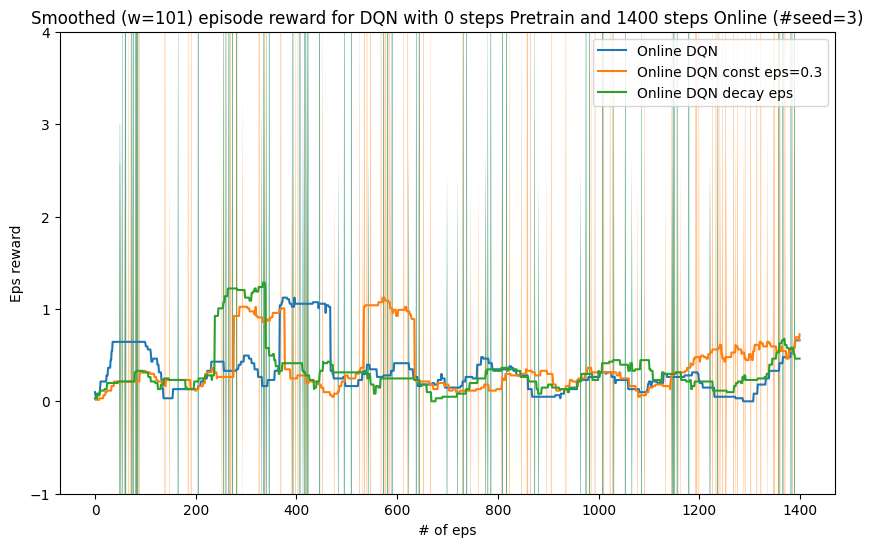

In [ ]:
x = range(n_steps)
# x = range(n_pretrain_eps + n_online_eps)
def moving_average(data, window_size):
    """Compute moving average using convolution."""
    window = np.ones(window_size) / window_size
    # return np.convolve(data, window, mode='valid')
    half_window = window_size // 2
    new_data = np.pad(data, (half_window, half_window), mode='reflect')  # Pad data to handle edges
    return np.convolve(new_data, window, mode='valid')

# mean_llama_LORO = np.mean(llama_LORO_rewards, axis = 1)
# std_llama_LORO = np.std(llama_LORO_rewards, axis = 1)
# mean_Qwen_LORO = np.mean(Qwen_LORO_rewards, axis = 1)
# std_Qwen_LORO = np.std(Qwen_LORO_rewards, axis = 1)
# mean_rand_LORO = np.mean(rand_LORO_rewards, axis = 1)
# std_rand_LORO = np.std(rand_LORO_rewards, axis = 1)
mean_onl = np.mean(onl_rewards, axis = 1)
std_onl = np.std(onl_rewards, axis = 1)
mean_onl_eps = np.mean(onl_rewards_eps, axis = 1)
std_onl_eps = np.std(onl_rewards_eps, axis = 1)
mean_onl_eps_decay = np.mean(onl_rewards_eps_decay, axis = 1)
std_onl_eps_decay = np.std(onl_rewards_eps_decay, axis = 1)

# mean_Qwen_LORO[:n_pretrain_eps] = Qwen_avg[:n_pretrain_eps]
# mean_llama_LORO[:n_pretrain_eps] = llama_avg[:n_pretrain_eps]
# mean_rand_LORO[:n_pretrain_eps] = rand_avg[:n_pretrain_eps]

# Smooth the data
window_size = 101  # Must be an odd number
# Qwen_LORO_y_smooth = moving_average(mean_Qwen_LORO, window_size)
# rand_LORO_y_smooth = moving_average(mean_rand_LORO, window_size)
# llama_LORO_y_smooth = moving_average(mean_llama_LORO, window_size)
onl_y_smooth = moving_average(mean_onl, window_size)
onl_y_eps_smooth = moving_average(mean_onl_eps, window_size)
onl_y_eps_decay_smooth = moving_average(mean_onl_eps_decay, window_size)

# std_onl = std_onl[window_size//2:-window_size//2 + 1]
# std_rand_LORO = std_rand_LORO[window_size//2:-window_size//2 + 1]
# std_Qwen_LORO = std_Qwen_LORO[window_size//2:-window_size//2 + 1]
# std_llama_LORO = std_llama_LORO[window_size//2:-window_size//2 + 1]
# x_smooth = x[window_size//2:-window_size//2 + 1]
x_smooth = x

# Create the plot
plt.figure(figsize=(10, 6))

plt.plot(onl_y_smooth, label='Online DQN')
plt.fill_between(x_smooth, onl_y_smooth-std_onl, onl_y_smooth+std_onl, alpha=0.5)
plt.plot(onl_y_eps_smooth, label='Online DQN const eps=0.3')
plt.fill_between(x_smooth, onl_y_eps_smooth-std_onl_eps, onl_y_eps_smooth+std_onl_eps, alpha=0.5)
plt.plot(onl_y_eps_decay_smooth, label='Online DQN decay eps')
plt.fill_between(x_smooth, onl_y_eps_decay_smooth-std_onl, onl_y_eps_decay_smooth+std_onl, alpha=0.5)
# plt.plot(Qwen_LORO_y_smooth, label='Finetune Qwen')
# plt.fill_between(x_smooth, Qwen_LORO_y_smooth-std_Qwen_LORO, Qwen_LORO_y_smooth+std_Qwen_LORO, alpha=0.5)
# plt.plot(rand_LORO_y_smooth, label='Finetune Rand')
# plt.fill_between(x_smooth, rand_LORO_y_smooth-std_rand_LORO, rand_LORO_y_smooth+std_rand_LORO, alpha=0.5)
# plt.plot(llama_LORO_y_smooth, label='Finetune Llama')
# plt.fill_between(x_smooth, llama_LORO_y_smooth-std_llama_LORO, llama_LORO_y_smooth+std_llama_LORO, alpha=0.5)

# plt.plot(Qwen_avg, label='Pretrain Qwen2.5-0.5B', linestyle=':')
# plt.plot(rand_avg, label='Pretrain Random', linestyle=':')
# plt.plot(llama_avg, label='Pretrain Llama', linestyle=':')

# Customize the plot
plt.title(f'Smoothed (w={window_size}) episode reward for DQN with {n_pretrain_steps} steps Pretrain and {n_steps} steps Online (#seed={n_exp})')
plt.xlabel('# of steps')
plt.ylabel('Eps reward')
plt.ylim(-1, 4)
plt.legend()
# plt.grid(True)

# Show the plot
plt.show()